# Customer Behaviour Analysis

# Objective
In this case study, you will be working on E-commerce Customer Behavior Analysis using Apache Spark, a powerful distributed computing framework designed for big data processing. This assignment aims to give you hands-on experience in analyzing large-scale e-commerce datasets using PySpark. You will apply techniques learned in data analytics to clean, transform, and explore customer behavior data, drawing meaningful insights to support business decision-making. Apart from understanding how big data tools can optimize performance on a single machine and across clusters, you will develop a structured approach to analyzing customer segmentation, purchase patterns, and behavioral trends.

# Business Value
E-commerce businesses operate in a highly competitive market where understanding customer behavior is critical to driving growth and retention. To stay ahead, companies must leverage data-driven insights to optimize marketing strategies, personalize customer experiences, and improve product offerings. In this assignment, you will analyze e-commerce transaction data to uncover patterns in purchasing behavior, customer preferences, and sales performance. With Apache Spark's ability to handle large datasets efficiently, businesses can process vast amounts of customer interactions in real-time, helping them make faster and more informed decisions.
As an analyst at an e-commerce company, your task is to examine historical transaction records and customer survey data to derive actionable insights that can drive business growth. Your analysis will help identify high-value customers, segment users based on behavior, and uncover trends in product demand and customer engagement. By leveraging big data analytics, businesses can enhance customer satisfaction, improve retention rates, and maximize revenue opportunities.


# Assignment Tasks
1. Data Preparation
2. Data Cleaning
3. Exploratory Data Analysis
4. Customer Segmentation (RFM Analysis) and Business Insights
5. Evaluation and Conclusion


# Dataset Overview
The dataset can be accessed the following [link](https://drive.google.com/drive/folders/1mBgC5tvZrh1bIBvpXVP_j-au5LFUAwOZ?usp=sharing).

The dataset used in this analysis comprises longitudinal purchase records from 5,027 Amazon.com users in the United States, spanning 2018 to 2022.

It is structured into three CSV files (amazon-purchases.csv, survey.csv, and fields.csv) that capture transactional data, demographic profiles, and survey responses.

Collected with informed consent, the dataset enables analysis of customer behavior, product preferences, and demographic trends.

**NOTE**: Personal identifiers (PII) were removed to ensure privacy, and all data were preprocessed by users before submission.

`Data Dictionary:`

| **Attribute**          | **Description** |
|------------------------|----------------|
| **Order Dates**        | The specific dates when orders were placed, enabling chronological analysis of sales trends. |
| **Title** |The name of the product purchased. |
|**Category** | The classification or group to which the product belongs, facilitating category-wise analysis. |
| **Pricing** | The cost per unit of each product, essential for revenue calculations and pricing strategy assessments. |
| **Quantities** | The number of units of each product ordered in a transaction, aiding in inventory and demand analysis. |
| **Shipping States**    | The states to which products were shipped, useful for geographical sales distribution analysis. |
| **Survey ResponseID**  | A unique identifier linking purchases to customer survey responses, enabling correlation between purchasing behavior and customer feedback. |



# Loading the Datasets

In [ ]:
## Installing the libraries if required
# !pip install --quiet pyspark==3.5.4 datasets==3.3.2 pandas==2.2.2 matplotlib==3.10.0 seaborn==0.13.2 numpy==1.26.4 tqdm==4.67.1

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession

# Initialise Spark session
spark = SparkSession.builder \
    .appName("Customer Behavior Analysis") \
    .getOrCreate()


# Load the paths to the datasets/csv files
amazon_purchases_path ="amazon-purchases.csv"
survey_path ="survey.csv"
fields_path ="fields.csv"

# Load datasets into PySpark DataFrames
amazon_purchases = spark.read.csv(amazon_purchases_path, header=True, inferSchema=True)
survey = spark.read.csv(survey_path, header=True, inferSchema=True)
fields = spark.read.csv(fields_path, header=True, inferSchema=True)

# Creating temporary SQL views for Dataframes
amazon_purchases.createOrReplaceTempView("amazon_purchases")
survey.createOrReplaceTempView("survey")
fields.createOrReplaceTempView("fields")

# Merge the datasets
merged_data = amazon_purchases.join(survey, on="Survey ResponseID", how="inner")




# Display the merged data
merged_data.show()

+-----------------+----------+-----------------------+--------+----------------------+--------------------+------------------------+--------------------+-------------+----------------+--------------------+-----------------+-----------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+--------------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|               Title|ASIN/ISBN (Product Code)|            Category|  Q-demos-age|Q-demos-hispanic|        Q-demos-race|Q-demos-education|   Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-us

In [ ]:
row_count = merged_data.count()
print(f"Number of rows in the dataset: {row_count}")
# Checking the schema of the merged_data set
merged_data.printSchema()

Number of rows in the dataset: 1811238
root
 |-- Survey ResponseID: string (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- Purchase Price Per Unit: double (nullable = true)
 |-- Quantity: double (nullable = true)
 |-- Shipping Address State: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ASIN/ISBN (Product Code): string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Q-demos-age: string (nullable = true)
 |-- Q-demos-hispanic: string (nullable = true)
 |-- Q-demos-race: string (nullable = true)
 |-- Q-demos-education: string (nullable = true)
 |-- Q-demos-income: string (nullable = true)
 |-- Q-demos-gender: string (nullable = true)
 |-- Q-sexual-orientation: string (nullable = true)
 |-- Q-demos-state: string (nullable = true)
 |-- Q-amazon-use-howmany: string (nullable = true)
 |-- Q-amazon-use-hh-size: string (nullable = true)
 |-- Q-amazon-use-how-oft: string (nullable = true)
 |-- Q-substance-use-cigarettes: string (nullable = true

There are 30 columns present in the  merged_dataset.

#1. Data Preparation

Before analysis, the data needs to be prepared to ensure consistency and efficiency.
- Check for data consistency and ensure all columns are correctly formatted.
- Structure and prepare the dataset for further processing, ensuring that relevant features are retained


In [ ]:
from pyspark.sql.functions import sum as spark_sum, col

# Check for missing values in the merged dataset

from pyspark.sql.functions import  isnull


# Check for missing values in all columns

missing_values_df = merged_data.select(
    [spark_sum(col(c).isNull().cast("int")).alias(c)for c in merged_data.columns]
)

# Show the count of missing values for each column
missing_values_df.show()



+-----------------+----------+-----------------------+--------+----------------------+-----+------------------------+--------+-----------+----------------+------------+-----------------+--------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+----------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|Title|ASIN/ISBN (Product Code)|Category|Q-demos-age|Q-demos-hispanic|Q-demos-race|Q-demos-education|Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-use-alcohol|Q-personal-diabetes|Q-personal-wheelchair|Q-life-changes|Q-sell-YOUR-data|

In [ ]:
# Calculate percentage of missing values for each column
from pyspark.sql.functions import col, sum as spark_sum

# Get total number of rows in the dataset
total_rows = merged_data.count()


missing_percentage_df = merged_data.select([
    ((spark_sum(col(c).isNull().cast("int")) / total_rows) * 100).alias(c) for c in merged_data.columns
])

# Show the result
missing_percentage_df.show()

+-----------------+----------+-----------------------+--------+----------------------+-----------------+------------------------+------------------+-----------+----------------+------------+-----------------+--------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+-----------------+----------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|            Title|ASIN/ISBN (Product Code)|          Category|Q-demos-age|Q-demos-hispanic|Q-demos-race|Q-demos-education|Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-use-alcohol|Q-personal-diabetes|Q-perso

5 columns('Shipping Address State','Title','ASIN/ISBN (Product Code)','Category','Q-life-changes') have missing values(<5%).Column named 'Q-life-changes' has more than 65% of missing values.So we can drop that column.

#2. Data Cleaning <font color = red>[20 marks]</font> <br>

Prepare the data for further analysis by performing data cleaning such as missing value treatment, handle data schema, outlier analysis, and relevant feature engineering techniques.

In [ ]:
# Checking distinct values in each column
for col_name in merged_data.columns:
    print(f"Value counts for column: {col_name}")
    merged_data.groupBy(col_name).count().orderBy("count", ascending=False).show()

Value counts for column: Survey ResponseID
+-----------------+-----+
|Survey ResponseID|count|
+-----------------+-----+
|R_8CXcySQawXPuJwJ| 5287|
|R_24csoaO569P4Yzz| 4699|
|R_2EglJpTWGEiwQYa| 4204|
|R_1QtQEfi1VAWgRM0| 3842|
|R_3e5g4lvddcnjkoZ| 3822|
|R_1PUcgnVG2i0EBz4| 3344|
|R_1o4IsRkXnLlSU6K| 3158|
|R_1rwrLVr6jBONnIg| 2944|
|R_32UZncFA03IrQwQ| 2939|
|R_3R4b0PxgHJiXxVD| 2890|
|R_bJI8lmXMZWL6oql| 2865|
|R_1NDq0rxoUSu6oyz| 2849|
|R_2z7rLZb69WuqDdf| 2830|
|R_3G1gYo1d23Zq8Np| 2758|
|R_32Mm71oAJq2K9XK| 2681|
|R_2VyUSFk11bbTVej| 2678|
|R_1NCzj2eSHI4QGcd| 2618|
|R_1C4nKyrv0w2thJn| 2599|
|R_r3IM83Ecq7eY7QJ| 2575|
|R_BWhnv4EdbhSS6rf| 2558|
+-----------------+-----+
only showing top 20 rows

Value counts for column: Order Date
+----------+-----+
|Order Date|count|
+----------+-----+
|2022-07-12| 4734|
|2021-06-21| 3819|
|2020-10-13| 3270|
|2022-07-13| 3190|
|2021-06-22| 2977|
|2022-11-25| 2928|
|2021-11-26| 2781|
|2020-11-27| 2662|
|2022-11-28| 2582|
|2019-07-15| 2554|
|2020-11-30| 2509|
|2021

Purchase Price Per Unit → Q1: 8.28, Q3: 22.99, IQR: 14.709999999999999
Outlier bounds → Lower: -13.784999999999998, Upper: 45.05499999999999


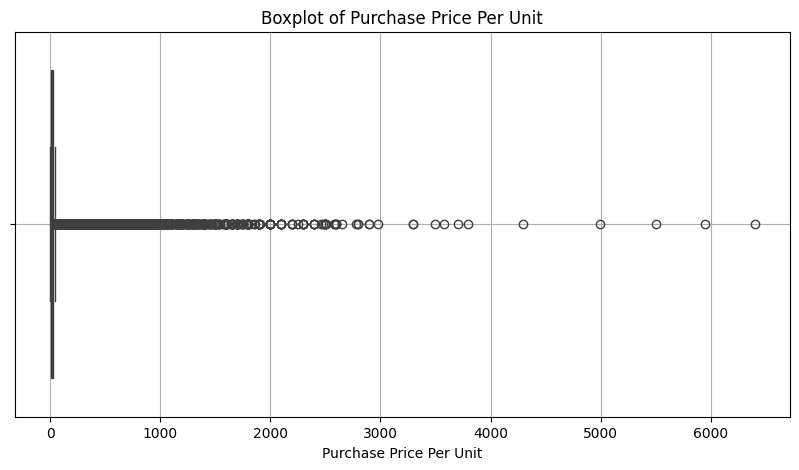

Quantity → Q1: 1.0, Q3: 1.0, IQR: 0.0
Outlier bounds → Lower: 1.0, Upper: 1.0


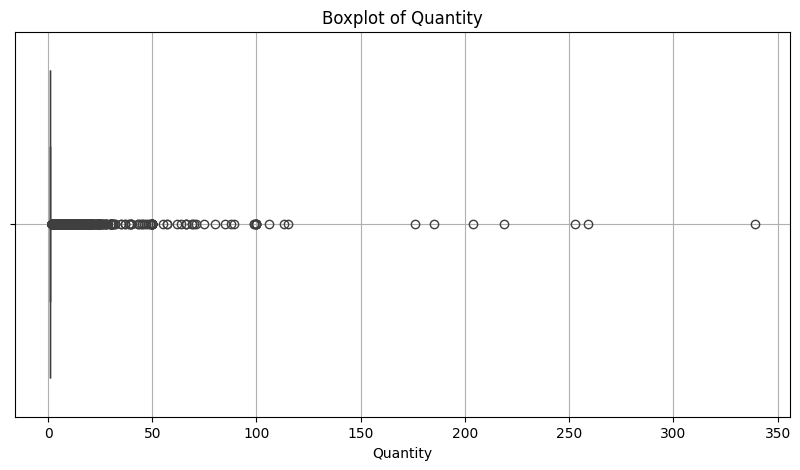

In [ ]:
# Checking outliers in the columns "Purchase Price Per Unit" and "Quantity"
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

def plot_outliers_boxplot(spark_df, column_name):
    # Step 1: Compute Q1, Q3 and IQR
    quantiles = spark_df.approxQuantile(column_name, [0.25, 0.75], 0.01)
    q1, q3 = quantiles
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    print(f"{column_name} → Q1: {q1}, Q3: {q3}, IQR: {iqr}")
    print(f"Outlier bounds → Lower: {lower_bound}, Upper: {upper_bound}")

    # Step 2: Select relevant column and convert to pandas
    pd_data = (
        spark_df
        .select(column_name)
        .filter(col(column_name).isNotNull())  # remove nulls
        .toPandas()
    )

    # Step 3: Plot boxplot
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=pd_data[column_name])
    plt.title(f"Boxplot of {column_name}")
    plt.xlabel(column_name)
    plt.grid(True)
    plt.show()
plot_outliers_boxplot(merged_data, "Purchase Price Per Unit")
plot_outliers_boxplot(merged_data, "Quantity")

## 2.1 Handling Missing values <font color = red>[10 marks]</font> <br>
Handle missing values in the data

In [ ]:
# Import necessary functions
from pyspark.sql.functions import when

# columns 'Shipping Address State','Title',ASIN/ISBN (Product Code)','Category' are categotical columns.
# Missing value is replacing with most frequent item in the columns
replacement_values = {
    'Shipping Address State': 'CA',
    'Title': 'Amazon.com Gift Card Balance Reload',
    'ASIN/ISBN (Product Code)': 'B00IX1I3G6',
    'Category': 'ABIS_BOOK'
}

# Fill missing values in the specified columns
merged_data = merged_data.fillna(replacement_values)

# Dropping the column 'Q-life-changes' from data set because of higher number missing values
merged_data=merged_data.drop('Q-life-changes')

# Check for missing values in all columns
missing_values_df = merged_data.select(
    [spark_sum(col(c).isNull().cast("int")).alias(c)for c in merged_data.columns]
)

# Show the count of missing values for each column again after imputation
missing_values_df.show()


+-----------------+----------+-----------------------+--------+----------------------+-----+------------------------+--------+-----------+----------------+------------+-----------------+--------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+----------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|Title|ASIN/ISBN (Product Code)|Category|Q-demos-age|Q-demos-hispanic|Q-demos-race|Q-demos-education|Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-use-alcohol|Q-personal-diabetes|Q-personal-wheelchair|Q-sell-YOUR-data|Q-sell-consumer-data|Q-small-b

Now the dataset has no missing values.

## 2.2 Feature Engineering <font color = red>[5 marks]</font> <br>
Perform feature engineering on the dataset to extract relevant/ create new features as required and map specific data types.

In [ ]:
from pyspark.sql.functions import col, month, year, to_date
from pyspark.sql.functions import dayofmonth

# Perform appropriate feature engineering. Eg. Extract order date, month, year and cast to the appropriate values
merged_data = merged_data.withColumn("Order Day", dayofmonth(col("Order Date")))

# Now, extract month and year
merged_data = merged_data.withColumn("Order Month", month(col("Order Date")))
merged_data = merged_data.withColumn("Order Year", year(col("Order Date")))

# Display the updated dataset
merged_data.show(5)

+-----------------+----------+-----------------------+--------+----------------------+--------------------+------------------------+-------------+-------------+----------------+--------------------+-----------------+-----------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------------+--------------------+---------------+------------+------------------+---------+-----------+----------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|               Title|ASIN/ISBN (Product Code)|     Category|  Q-demos-age|Q-demos-hispanic|        Q-demos-race|Q-demos-education|   Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substanc

3 columns named 'Order Day','Order Month','Order Year' created from the column 'Order Date'

In [ ]:
# Split multiple race categories into an array and explode into separate rows

merged_data.groupBy("Q-demos-race").count().orderBy("count", ascending=False).show()

from pyspark.sql.functions import split, explode, col

# Split multiple race categories into an array and explode into separate rows
merged_data = merged_data.withColumn("Q-demos-race", explode(split(col("Q-demos-race"), ",")))

# Checking count of distinct entries in the column after grouping similar column entries
print("count after grouping similar column entries")
merged_data.groupBy("Q-demos-race").count().orderBy("count", ascending=False).show()

+--------------------+-------+
|        Q-demos-race|  count|
+--------------------+-------+
|  White or Caucasian|1473706|
|Black or African ...| 103580|
|               Asian| 101324|
|               Other|  27737|
|White or Caucasia...|  27614|
|White or Caucasia...|  25336|
|White or Caucasia...|  19738|
|American Indian/N...|   8514|
|White or Caucasia...|   7119|
|White or Caucasia...|   3841|
|Asian,Native Hawa...|   2834|
|Black or African ...|   1441|
|Black or African ...|   1301|
|Black or African ...|   1257|
|White or Caucasia...|   1187|
|White or Caucasia...|    939|
|Native Hawaiian o...|    862|
|White or Caucasia...|    772|
|White or Caucasia...|    760|
|White or Caucasia...|    480|
+--------------------+-------+
only showing top 20 rows

count after grouping similar column entries
+--------------------+-------+
|        Q-demos-race|  count|
+--------------------+-------+
|  White or Caucasian|1562102|
|Black or African ...| 139181|
|               Asian| 137306|


In [ ]:
# Handling 'Title' column
merged_data.groupBy("Title").count().orderBy("count", ascending=False).show()

# cleanup the "Title column with entry "1"
from pyspark.sql.functions import col
merged_data = merged_data.filter(col("Title") != "1")
print("count after cleanup")
merged_data.groupBy("Title").count().orderBy("count", ascending=False).show()

#Dropping irrelevent columns from the dataset
merged_data=merged_data.drop('Q-substance-use-cigarettes',
 'Q-substance-use-marijuana',
 'Q-substance-use-alcohol',
 'Q-personal-diabetes',
 'Q-personal-wheelchair',
 'Q-sell-YOUR-data',
 'Q-sell-consumer-data',
 'Q-small-biz-use',
 'Q-census-use',
 'Q-research-society')






+--------------------+------+
|               Title| count|
+--------------------+------+
|Amazon.com Gift C...|106508|
|       Amazon Reload|  6556|
|Amazon.com eGift ...|  5689|
|Google Play gift ...|   896|
|Group Gift Weddin...|   734|
|$10 -PlayStation ...|   673|
|Amazon Basics 36 ...|   594|
|Amazon Basics 48 ...|   585|
|Apple Gift Card -...|   576|
|                   1|   572|
|Uber Gift Card - ...|   550|
|Dr. Elsey’s Premi...|   528|
|Echo Dot (3rd Gen...|   510|
|Fire TV Stick 4K ...|   491|
|Amazon eGift Card...|   486|
|Dole Bananas, 2 l...|   441|
|$10 Xbox Gift Car...|   435|
|Amazon.com Gift C...|   428|
|$20 PlayStation S...|   417|
|DoorDash Gift Car...|   411|
+--------------------+------+
only showing top 20 rows

count after cleanup
+--------------------+------+
|               Title| count|
+--------------------+------+
|Amazon.com Gift C...|106508|
|       Amazon Reload|  6556|
|Amazon.com eGift ...|  5689|
|Google Play gift ...|   896|
|Group Gift Weddin...|  

In [ ]:
from pyspark.sql.functions import col

# Rename multiple columns
merged_data = merged_data \
    .withColumnRenamed("Q-demos-age", "age") \
    .withColumnRenamed("Q-demos-hispanic", "Spanish, Hispanic or Latino origin") \
    .withColumnRenamed("Q-demos-race", "race")\
    .withColumnRenamed("Q-demos-education", "education")\
    .withColumnRenamed("Q-demos-income", "income")\
    .withColumnRenamed("Q-demos-gender", "gender")\
    .withColumnRenamed("Q-sexual-orientation", "sexual_orientation")\
    .withColumnRenamed("Q-demos-state", "state")\
    .withColumnRenamed("Q-amazon-use-howmany", "amazon_use_howmany")\
    .withColumnRenamed("Q-amazon-use-hh-size", "amazon_use_household_size")\
    .withColumnRenamed("Q-amazon-use-how-oft", "amazon_use_how_often")
# Display the data set
merged_data.show()


+-----------------+----------+-----------------------+--------+----------------------+--------------------+------------------------+--------------------+-------------+----------------------------------+--------------------+-----------------+-----------------+------+--------------------+----------+------------------+-------------------------+--------------------+---------+-----------+----------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|               Title|ASIN/ISBN (Product Code)|            Category|          age|Spanish, Hispanic or Latino origin|                race|        education|           income|gender|  sexual_orientation|     state|amazon_use_howmany|amazon_use_household_size|amazon_use_how_often|Order Day|Order Month|Order Year|
+-----------------+----------+-----------------------+--------+----------------------+--------------------+------------------------+--------------------+-------------+----------------------------------+--

In [ ]:
from pyspark.sql.functions import create_map, lit
from itertools import chain

# Map categorical income to numerical values
income_mapping = {
    'Less than $25,000': 0,
    '$25,000 - $49,999': 1,
    '$50,000 - $74,999': 2,
    '$75,000 - $99,999': 3,
    '$100,000 - $149,999': 4,
    '$150,000 or more': 5,
    'Prefer not to say': 6 # added extra one more  mapping to consider the entry 'Prefer not to say'
}

# Create a mapping expression for income
income_mapping_expr = create_map([lit(x) for x in chain(*income_mapping.items())])

# Apply the mapping to the 'Income' column
merged_data = merged_data.withColumn("income", income_mapping_expr.getItem(col("income")))

# Map gender to numerical values
gender_mapping = {
    'Male': 0,
    'Female': 1,
    'Other': 2,
    'Prefer not to say':3
}

# Create a mapping expression for gender
gender_mapping_expr = create_map([lit(x) for x in chain(*gender_mapping.items())])

# Apply the mapping to the 'Gender' column
merged_data = merged_data.withColumn("gender", gender_mapping_expr.getItem(col("gender")))

# Display the updated dataset
merged_data.show()


/usr/local/lib/python3.11/dist-packages/pyspark/sql/column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


+-----------------+----------+-----------------------+--------+----------------------+--------------------+------------------------+--------------------+-------------+----------------------------------+--------------------+-----------------+------+------+--------------------+----------+------------------+-------------------------+--------------------+---------+-----------+----------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|               Title|ASIN/ISBN (Product Code)|            Category|          age|Spanish, Hispanic or Latino origin|                race|        education|income|gender|  sexual_orientation|     state|amazon_use_howmany|amazon_use_household_size|amazon_use_how_often|Order Day|Order Month|Order Year|
+-----------------+----------+-----------------------+--------+----------------------+--------------------+------------------------+--------------------+-------------+----------------------------------+--------------------+---

In [ ]:
# Analysing the count of distinct entries after mapping
merged_data.groupBy("gender").count().orderBy("count", ascending=False).show()
merged_data.groupBy("income").count().orderBy("count", ascending=False).show()

+------+-------+
|gender|  count|
+------+-------+
|     1|1110118|
|     0| 765665|
|     2|  38524|
|     3|   1380|
+------+-------+

+------+------+
|income| count|
+------+------+
|     4|396315|
|     2|377575|
|     1|364351|
|     3|312767|
|     5|259450|
|     0|182947|
|     6| 22282|
+------+------+





*   Count of female is more
*   Income group '\$100,000 - $149,999' count is more compared to othe income groups



## 2.3 Data Cleaning <font color = red>[5 marks]</font> <br>
Handle data cleaning techniques such as data duplication, dropping unnecessary values etc.

In [ ]:
# Check for duplicates
print("Number of Duplicates:", merged_data.count() - merged_data.dropDuplicates().count())

# Remove duplicates
merged_data = merged_data.dropDuplicates()

# Verify duplicates after cleaning
print("Number of Duplicates After Cleaning:", merged_data.count() - merged_data.dropDuplicates().count())

Number of Duplicates: 11838
Number of Duplicates After Cleaning: 0


In [ ]:
cleaned_data_path = 'CaseStudy'
merged_data.write.csv(cleaned_data_path, header=True, mode='overwrite')

# Load the cleaned dataset from the location
cleaned_data = spark.read.csv(cleaned_data_path, header=True, inferSchema=True)

# Display the first few rows
print("Cleaned Data:")
cleaned_data.show(5)

Cleaned Data:
+-----------------+----------+-----------------------+--------+----------------------+--------------------+------------------------+------------------+-------------+----------------------------------+------------------+-----------------+------+------+--------------------+------------+------------------+-------------------------+--------------------+---------+-----------+----------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|               Title|ASIN/ISBN (Product Code)|          Category|          age|Spanish, Hispanic or Latino origin|              race|        education|income|gender|  sexual_orientation|       state|amazon_use_howmany|amazon_use_household_size|amazon_use_how_often|Order Day|Order Month|Order Year|
+-----------------+----------+-----------------------+--------+----------------------+--------------------+------------------------+------------------+-------------+----------------------------------+----------------

# 3. Exploratory Data Analysis <font color = red>[55 marks]</font> <br>

In [ ]:
# Checking the columns of cleaned_data
cleaned_data.columns

['Survey ResponseID',
 'Order Date',
 'Purchase Price Per Unit',
 'Quantity',
 'Shipping Address State',
 'Title',
 'ASIN/ISBN (Product Code)',
 'Category',
 'age',
 'Spanish, Hispanic or Latino origin',
 'race',
 'education',
 'income',
 'gender',
 'sexual_orientation',
 'state',
 'amazon_use_howmany',
 'amazon_use_household_size',
 'amazon_use_how_often',
 'Order Day',
 'Order Month',
 'Order Year']

## 3.1 Analyse purchases by hour, day and month <font color = red>[5 marks]</font> <br>

Examine overall trends in purchases over time and analyse the trends by hour, day, month.

<ipython-input-14-23d9031bfbb1>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Order Day", y="count", data=daily_purchases_pd,palette="Oranges_d", ax=axes[1])
<ipython-input-14-23d9031bfbb1>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
<ipython-input-14-23d9031bfbb1>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Order Month", y="count", data=monthly_purchases_pd,palette="Greens_d", ax=axes[2])


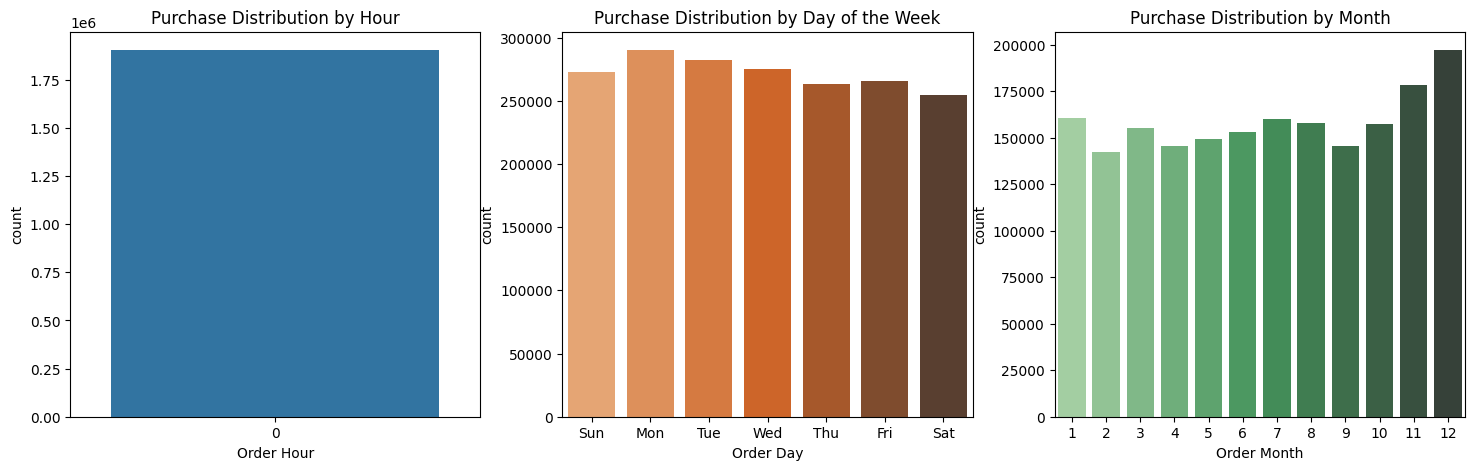

In [ ]:
# Purchase Distribution by Hour, Day, and Month

from pyspark.sql.functions import hour, dayofweek, month
import seaborn as sns
import matplotlib.pyplot as plt

# Extract hour, day, and month

cleaned_data = cleaned_data.withColumn("Order Hour", hour(col("Order Date")))
cleaned_data = cleaned_data.withColumn("Order Day", dayofweek(col("Order Date")))  # 1 = Sunday, 7 = Saturday


# Group and count purchases by time factors
hourly_purchases = cleaned_data.groupBy("Order Hour").count().orderBy("Order Hour")
daily_purchases = cleaned_data.groupBy("Order Day").count().orderBy("Order Day")
monthly_purchases = cleaned_data.groupBy("Order Month").count().orderBy("Order Month")

# Convert to Pandas for visualisation
hourly_purchases_pd = hourly_purchases.toPandas()
daily_purchases_pd = daily_purchases.toPandas()
monthly_purchases_pd = monthly_purchases.toPandas()

# Plot the data
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Hourly Distribution
sns.barplot(x="Order Hour", y="count", data=hourly_purchases_pd, ax=axes[0])
axes[0].set_title("Purchase Distribution by Hour")

# Daily Distribution
sns.barplot(x="Order Day", y="count", data=daily_purchases_pd,palette="Oranges_d", ax=axes[1])
axes[1].set_title("Purchase Distribution by Day of the Week")
axes[1].set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])

# Monthly Distribution
sns.barplot(x="Order Month", y="count", data=monthly_purchases_pd,palette="Greens_d", ax=axes[2])
axes[2].set_title("Purchase Distribution by Month")

plt.show()




*   **Purchase Distribution by Hour:**

All purchases show up in hour = 0, indicating that the Order Date  missing timestamp info (just date, no time).

*  **Purchase Distribution by Day of the Week:**

Most purchases occur on Monday and Tuesday.

*   **Purchase Distribution by Month:**

December shows the highest number of purchases (likely due to holiday shopping).Slight dip around February and September




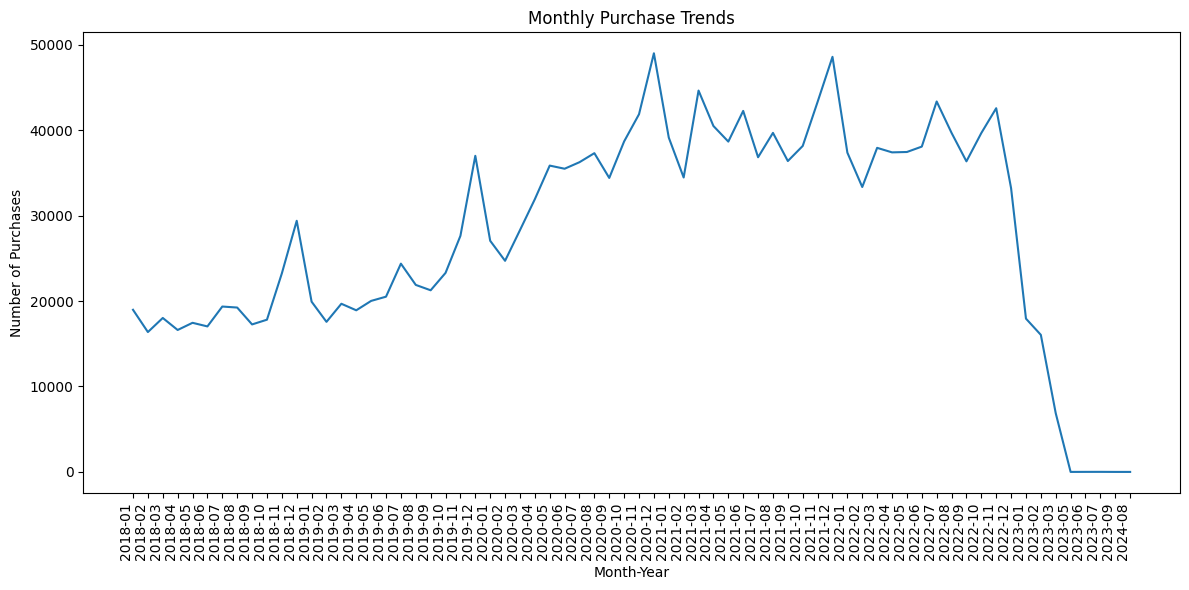

In [ ]:
# Monthly Purchase Trends

from pyspark.sql.functions import date_format

# Extract month and year from 'Order Date'
cleaned_data = cleaned_data.withColumn("OrderMonthYear", date_format(col("Order Date"), "yyyy-MM"))


# Group by month and count purchases
monthly_purchases = cleaned_data.groupBy("OrderMonthYear").count().orderBy("OrderMonthYear")


# Convert to Pandas for visualisation
monthly_purchases_pd = monthly_purchases.toPandas()


# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x="OrderMonthYear", y="count", data=monthly_purchases_pd)
plt.title("Monthly Purchase Trends")
plt.xlabel("Month-Year")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


 **Monthly Purchase Trends Summary**
*   In 2018,purchase was almost stable.
*   Clear upward trend starting mid-2020, peaking around late 2021.Likely driven by pandemic-related online shopping surge.
*   Sharp Decline (2023 Onward):Steep drop begins early 2023.By mid-2023, purchases almost flatlined.

<ipython-input-19-a2fddb518bb7>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Order Year", y="count", data=yearly_purchases_pd, palette="rocket")


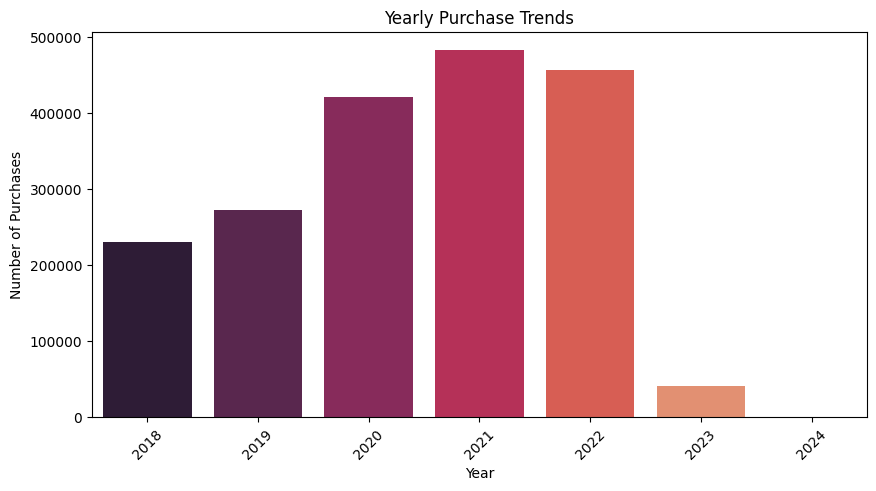

In [ ]:
# Yealy Purchase Trends

from pyspark.sql.functions import date_format


# Group by Year and count purchases
yearly_purchases = cleaned_data.groupBy("Order Year").count().orderBy("Order Year")


# Convert to Pandas for visualisation
yearly_purchases_pd = yearly_purchases.toPandas()


# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(x="Order Year", y="count", data=yearly_purchases_pd, palette="rocket")
plt.title("Yearly Purchase Trends")
plt.xlabel("Year")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=45)
plt.show()




*   Strong Growth (2018–2021):
Purchases rose steadily from ~230k in 2018 to nearly 490k in 2021 — likely driven by increased Amazon usage over time, possibly influenced by the pandemic in 2020–2021.

* Slight Dip in 2022:
Purchases dropped a bit in 2022 (~460k), but still remained high — this could reflect stabilization after the pandemic surge.

* Sharp Decline in 2023 and 2024:List item




## 3.2 Customer Demographics vs Purchase Frequency <font color = red>[5 marks]</font> <br>
Analyse the trends between the customer deographics and the purchase frequency

<ipython-input-20-7387eb37c614>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


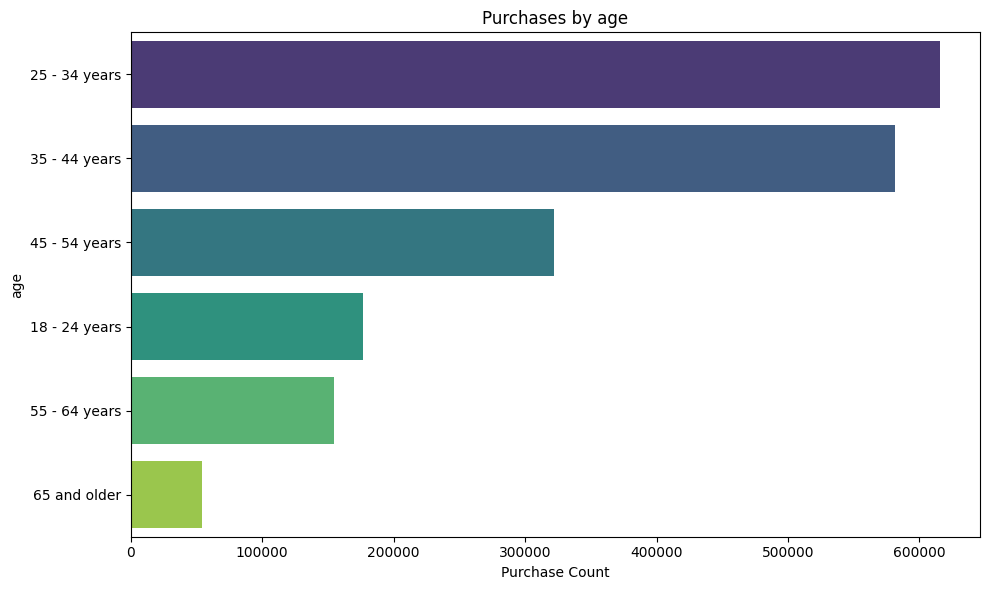

<ipython-input-20-7387eb37c614>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


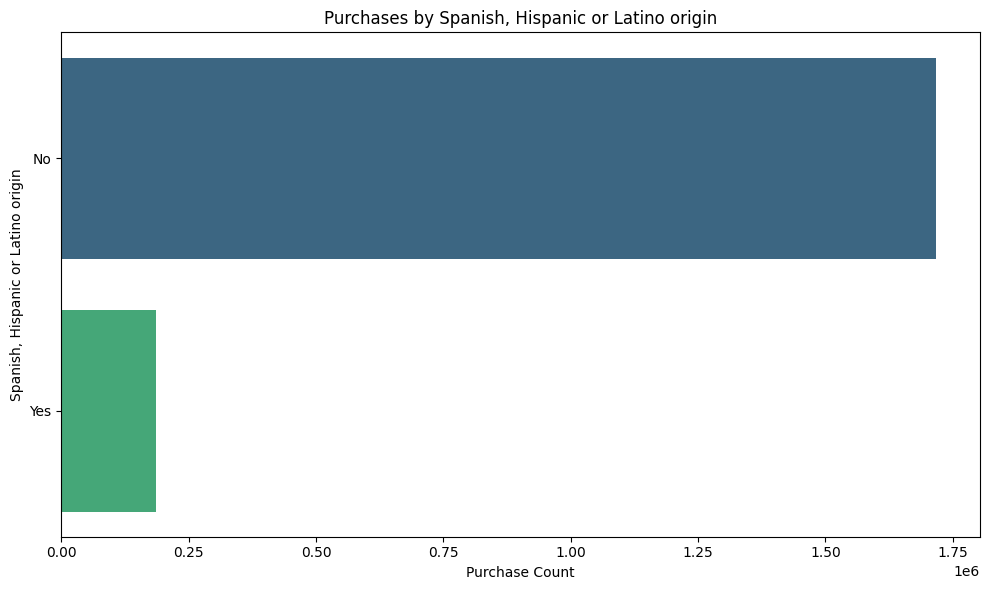

<ipython-input-20-7387eb37c614>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


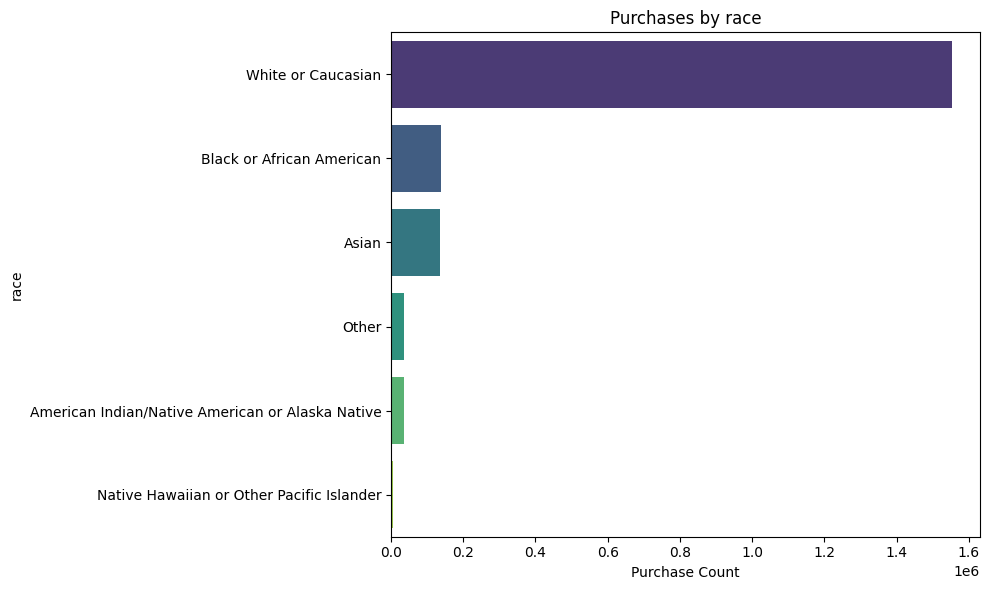

<ipython-input-20-7387eb37c614>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


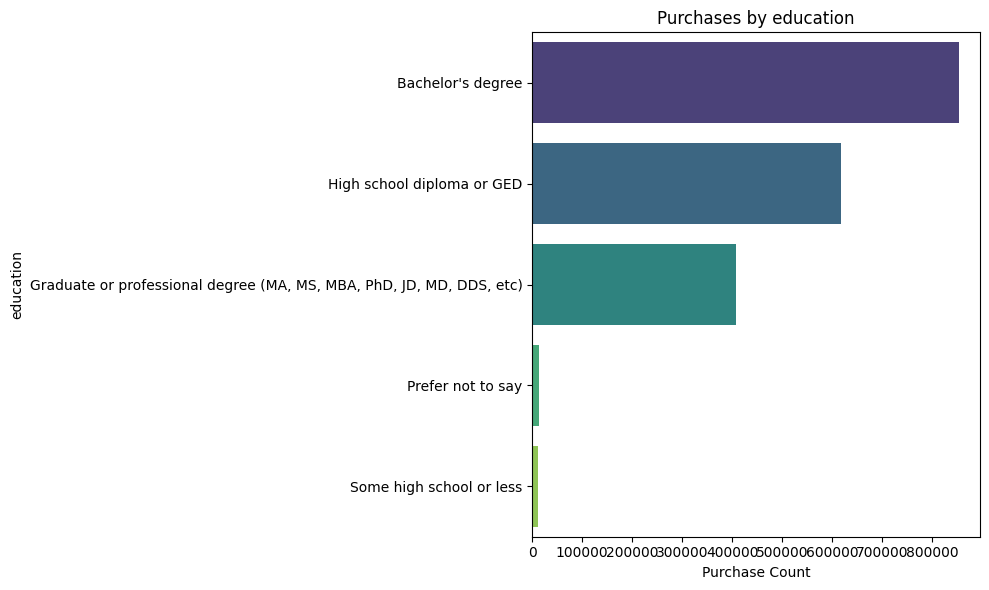

<ipython-input-20-7387eb37c614>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


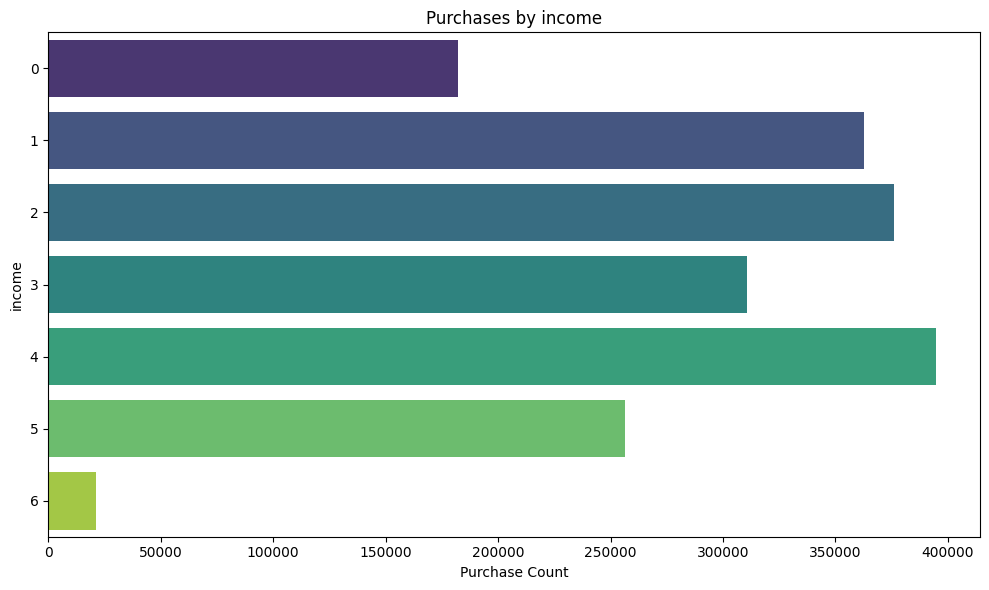

<ipython-input-20-7387eb37c614>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


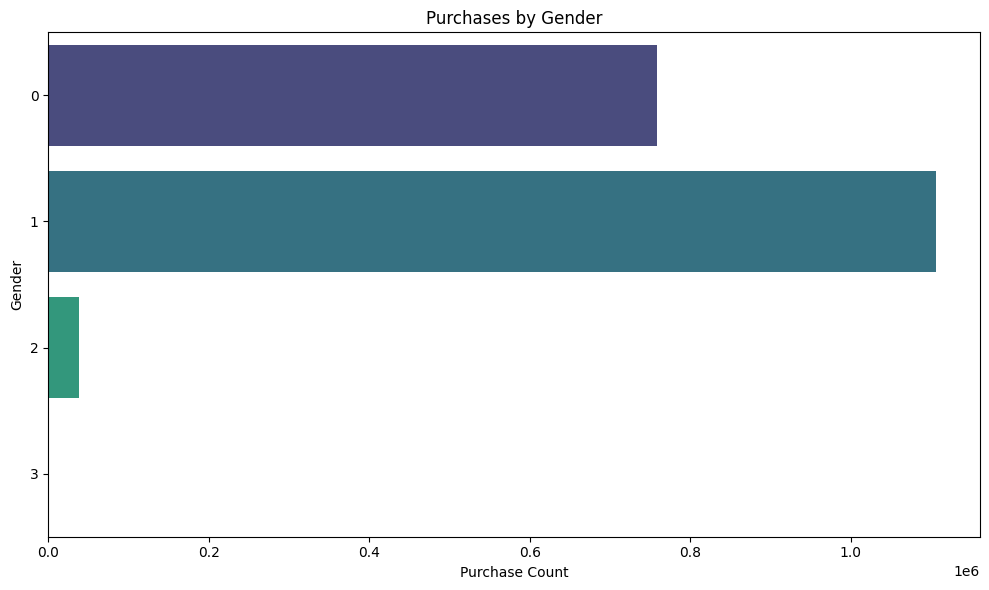

<ipython-input-20-7387eb37c614>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


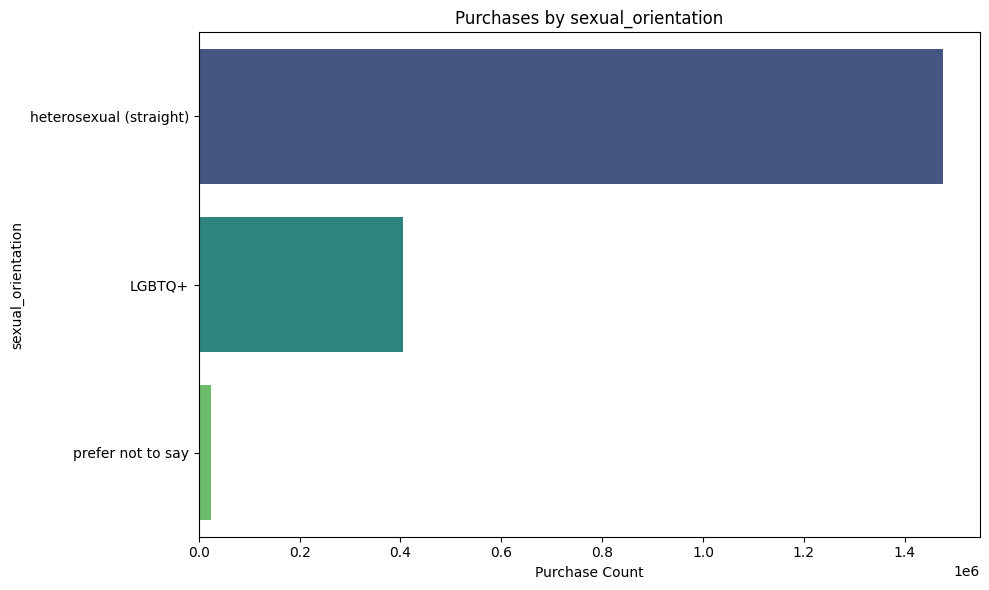

<ipython-input-20-7387eb37c614>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


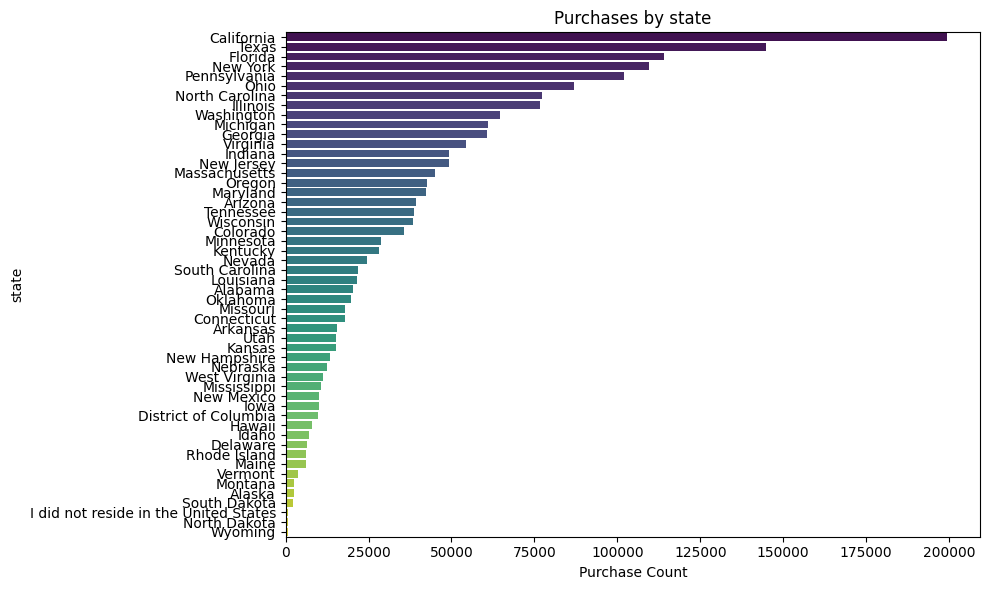

In [ ]:
# Correlation Between Demographics and Purchase Frequency
from pyspark.sql.functions import count, col
import matplotlib.pyplot as plt
import seaborn as sns

# Define demographic columns
demographic_columns = [
    "age",
    "Spanish, Hispanic or Latino origin",
    "race",
    "education",
    "income",
    "Gender",
    "sexual_orientation",
    "state"
]


for col_name in demographic_columns:
    # Use backticks if the column name has spaces
    safe_col = f"`{col_name}`" if " " in col_name else col_name

    # Aggregate purchase counts per demographic group
    demo_df = (
        cleaned_data.where(col(safe_col).isNotNull())
        .groupBy(safe_col)
        .agg(count("*").alias("Purchase Count"))
        .orderBy("Purchase Count", ascending=False)
        .toPandas()
    )

    # Plot

    if not demo_df.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=demo_df,
            y=col_name,
            x="Purchase Count",
            palette="viridis",
            orient="h"
        )
        plt.title(f"Purchases by {col_name}")
        plt.xlabel("Purchase Count")
        plt.ylabel(col_name)
        plt.tight_layout()
        plt.show()




*   Purchase by age is more for age group 25-34 years
*   Income '\$100,000 - $149,999' group purchased more
*   Female is purchase more than male
*  'White  or Caucasion' purchase count is more



## 3.3 Purchase behavior weekend vs weekday <font color = red>[5 marks]</font> <br>

Compare the purchase behavior of customer's on weekdays vs. weekends.

<ipython-input-21-a5532e48ffca>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="DayType", y="count", palette="Set2",data=weekday_weekend_purchases_pd)


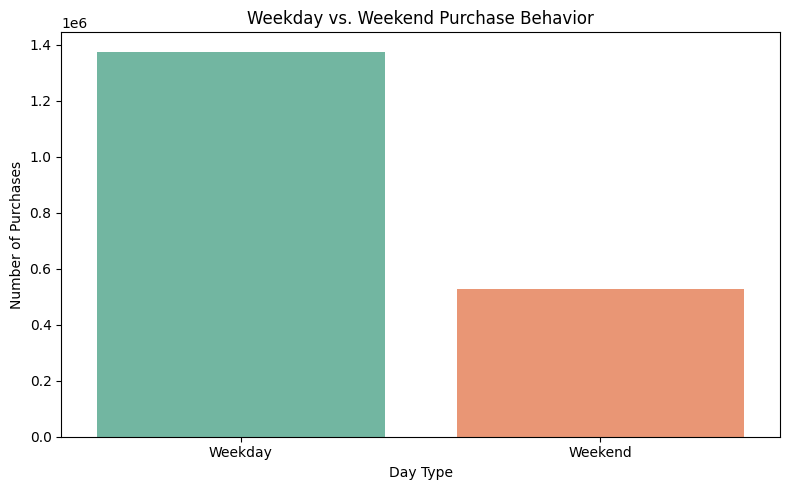

In [ ]:
# Weekday vs. Weekend Purchase Behavior

from pyspark.sql.functions import when
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define weekdays and weekends
cleaned_data = cleaned_data.withColumn("DayType", when(col("Order Day").isin(2, 3, 4, 5, 6), "Weekday").otherwise("Weekend"))


# Group and count purchases
weekday_weekend_purchases = cleaned_data.groupBy("DayType").count().orderBy("DayType")


# Convert to Pandas for visualisation
weekday_weekend_purchases_pd = weekday_weekend_purchases.toPandas()

# Plot
plt.figure(figsize=(8, 5))  # Adjust figure size if needed
sns.barplot(x="DayType", y="count", palette="Set2",data=weekday_weekend_purchases_pd)
plt.title("Weekday vs. Weekend Purchase Behavior")
plt.xlabel("Day Type")
plt.ylabel("Number of Purchases")
plt.tight_layout()
plt.show()



*   Weekday purchases significantly outnumber weekend purchases.This suggests users tend to shop more during the week




## 3.4 Frequently purchased product pairs <font color = red>[5 marks]</font> <br>

Analyze how frequently products are purchased together (also known as Market Basket Analysis)


Frequently Purchased Product Pairs:
         product_pairs_str  frequency
0   B086KKT3RX, B00GAC1D2G         24
1   B004RMK4BC, B00GAC1D2G         21
2   B00NTCH52W, B00NTCHCU2         21
3   B01MZEEFNX, B07PCMWTSG         15
4   B00N1NBOV2, B004LLIKVU         12
5   B00MPQ5ZOS, B07PCMWTSG         12
6   B086KKT3RX, B07DC5PPFV         11
7   B004RMK4BC, B086KKT3RX         10
8   B00IX1I3G6, B01M1NQ1CE         10
9   B079QHML21, B073JYC4XM          9
10  B01FIS82WQ, B004LLIKVU          9
11  B07MB4HN9X, B00IX1I3G6          9
12  B00T0C9XRK, B07F9KMY2T          9
13  B00IX1I3G6, B072KPZMMV          9
14  B06XKHNCZW, B0785RNKZS          8
15  B0791TX5P5, B07CVX3516          8
16  B001W3T2SK, B08LJVQSL2          8
17  B086KKT3RX, B00T0C9XRK          8
18  B006MISZOC, B00IX1I3G6          8
19  B00DOJG6RA, B00N1NBOV2          7


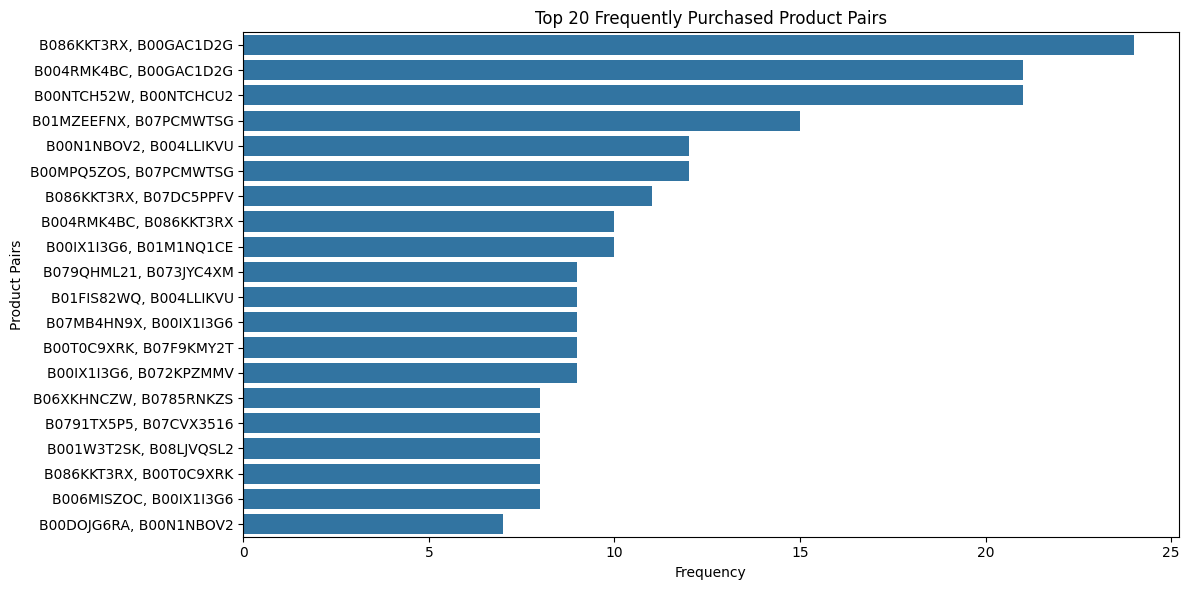

In [ ]:
# Frequently Purchased Product Pairs (Market Basket Analysis)
from pyspark.sql.functions import collect_set, explode, count, expr, size, array_distinct, array_join
from pyspark.sql import functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Group purchases by customer and collect items bought together
customer_products = cleaned_data.groupBy("Survey ResponseID").agg(collect_set("ASIN/ISBN (Product Code)").alias("products"))

# Explode item pairs
# Filter out customers with less than 2 purchases to avoid errors
customer_products = customer_products.filter(size(customer_products["products"]) >= 2)

# Create combinations using array functions and explode
product_pairs = customer_products.withColumn(
    "product_pairs",
    F.explode(F.expr("transform(sequence(0, size(products) - 2), i -> slice(products, i + 1, 2))"))
).select("Survey ResponseID", "product_pairs")

# Convert the 'product_pairs' column (list) to a string for plotting
product_pairs = product_pairs.withColumn("product_pairs_str", array_join("product_pairs", ", "))

# Count co-occurrences of items
pair_counts = product_pairs.groupBy("product_pairs_str").agg(count("*").alias("frequency")).orderBy("frequency", ascending=False)

# Convert to Pandas for visualization
pair_counts_pd = pair_counts.limit(20).toPandas()  # Limit to top 20 for visualization

# Print the frequently purchased product pairs (optional)
print("Frequently Purchased Product Pairs:")
print(pair_counts_pd)

# Plotting the results (using 'product_pairs_str' instead of 'product_pairs')
plt.figure(figsize=(12, 6))
sns.barplot(x="frequency", y="product_pairs_str", data=pair_counts_pd, orient="h")
plt.title("Top 20 Frequently Purchased Product Pairs")
plt.xlabel("Frequency")
plt.ylabel("Product Pairs")
plt.tight_layout()
plt.show()



*   The top pair, B086KKT3RX and B00GAC1D2G, was bought together 24 times, the highest in the dataset.



## 3.5 Examine Product Performance <font color = red>[5 marks]</font> <br>

Examine the performance of products by calculating revenue and item popularity.

<ipython-input-22-bbb7a788c6ad>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


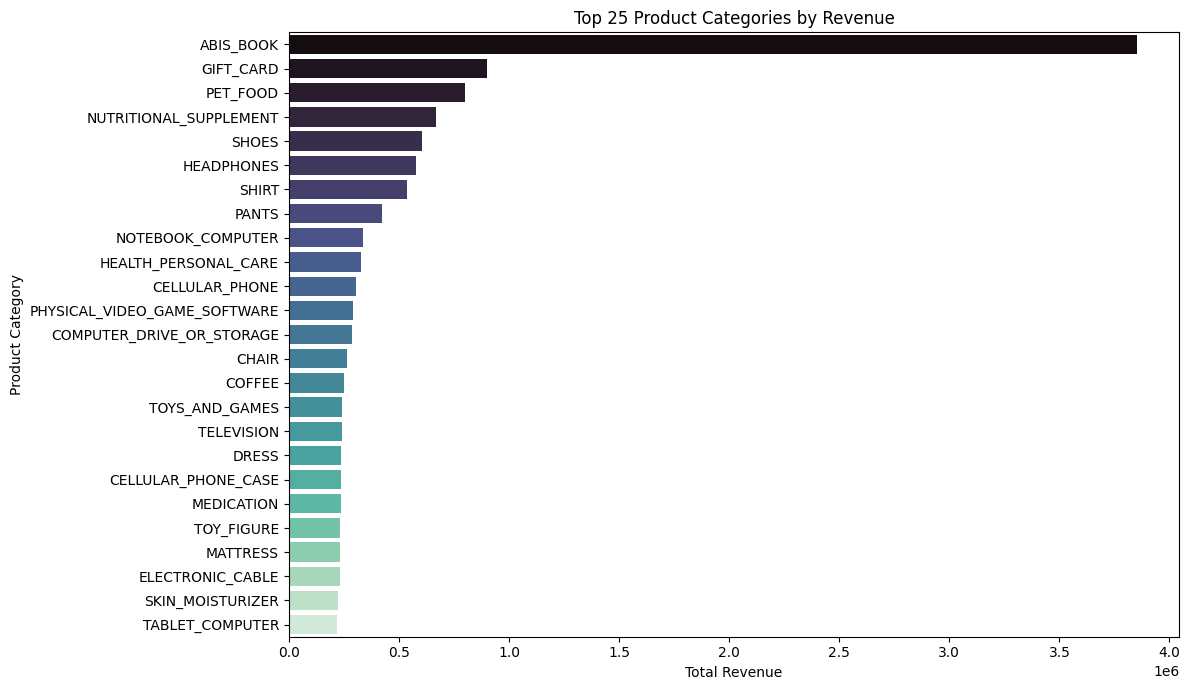

<ipython-input-22-bbb7a788c6ad>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


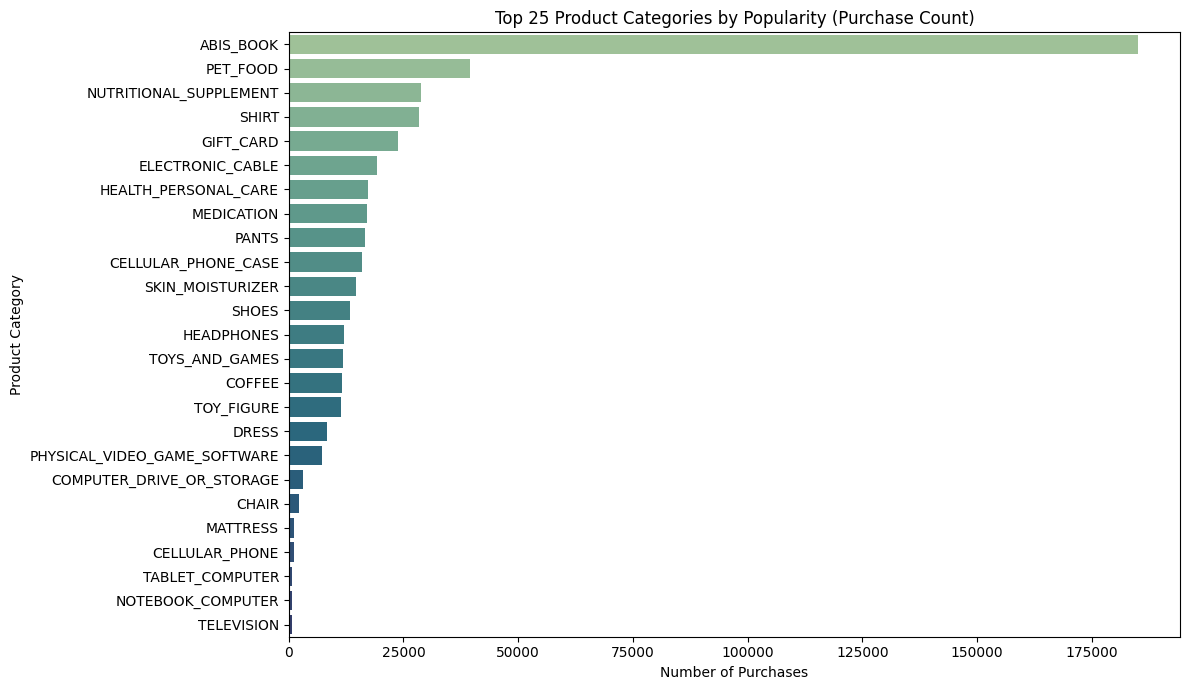

In [ ]:
# Contribution of Product Categories (Top 25)

from pyspark.sql.functions import col, sum as _sum, count

# Calculate Revenue = Purchase Price Per Unit * Quantity
cleaned_data = cleaned_data.withColumn("Revenue", col("Purchase Price Per Unit") * col("Quantity"))

# Group by Product Category and compute:

product_perf = cleaned_data.groupBy("Category").agg(
    _sum("Revenue").alias("Total Revenue"),
    count("*").alias("Purchase Count")
)

# Convert to Pandas for visualization
product_perf_pd = product_perf.orderBy(col("Total Revenue").desc()).toPandas()

# Limit to Top 25 Categories by Revenue
top_25 = product_perf_pd.head(25)

# STEP 5: Plot Revenue and Popularity
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(12, 7))

# Barplot for Revenue
sns.barplot(
    data=top_25,
    y="Category",
    x="Total Revenue",
    ax=ax1,
    palette="mako"
)
ax1.set_title("Top 25 Product Categories by Revenue")
ax1.set_xlabel("Total Revenue")
ax1.set_ylabel("Product Category")
plt.tight_layout()
plt.show()

# Plot by Popularity
plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_25.sort_values("Purchase Count", ascending=False),
    y="Category",
    x="Purchase Count",
    palette="crest"
)
plt.title("Top 25 Product Categories by Popularity (Purchase Count)")
plt.xlabel("Number of Purchases")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()



*   This visualization clearly highlights "ABIS_BOOK" as the dominant revenue driver by a large margin, far outpacing all other categories.




## 3.6 Top products by quantity <font color = red>[5 marks]</font> <br>

Identify the most frequently purchased products.

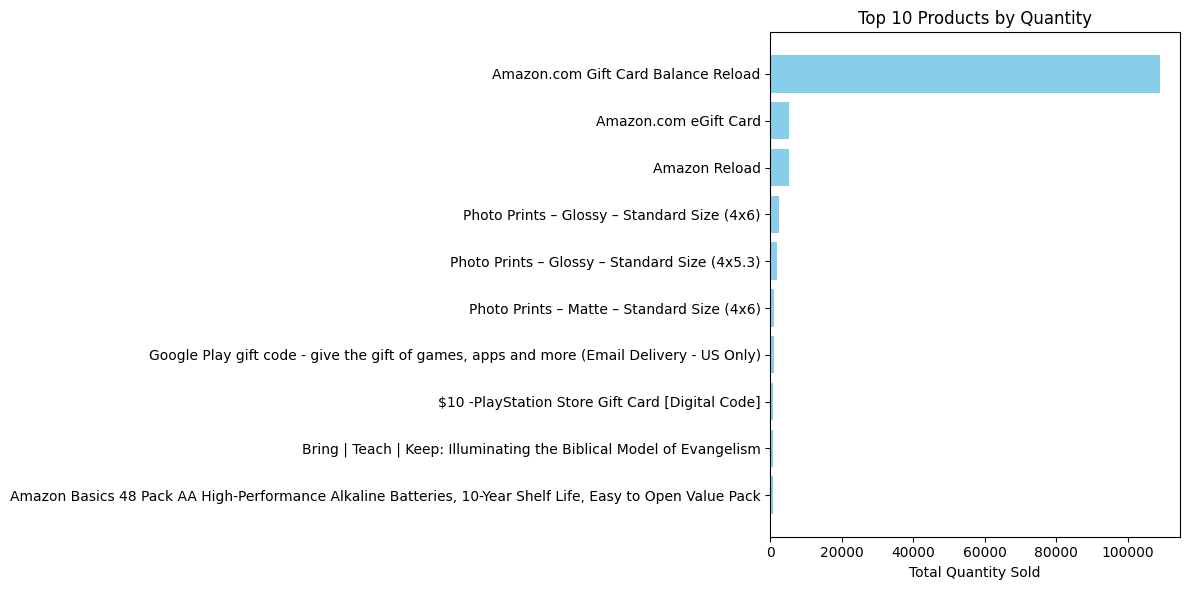

In [ ]:
# Top 10 Products by Quantity

# Group by product title and sum 'Quantity'
top_products = cleaned_data.groupBy("Title") \
    .sum("Quantity") \
    .withColumnRenamed("sum(Quantity)", "Total_Quantity") \
    .orderBy("Total_Quantity", ascending=False) \
    .limit(10)

# Convert to Pandas for visualisation
top_products_pd = top_products.toPandas()

# Plot using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(top_products_pd["Title"], top_products_pd["Total_Quantity"], color='skyblue')
plt.xlabel("Total Quantity Sold")
plt.title("Top 10 Products by Quantity")
plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()




*   Gift cards dominate the top positions, indicating they are the most popular products by quantity sold.
*   Personalized items like photo prints  also show significant demand



## 3.7 Distribution of Purchases by State <font color = red>[5 marks]</font> <br>

Analyze the distribution of purchases across states and categories.

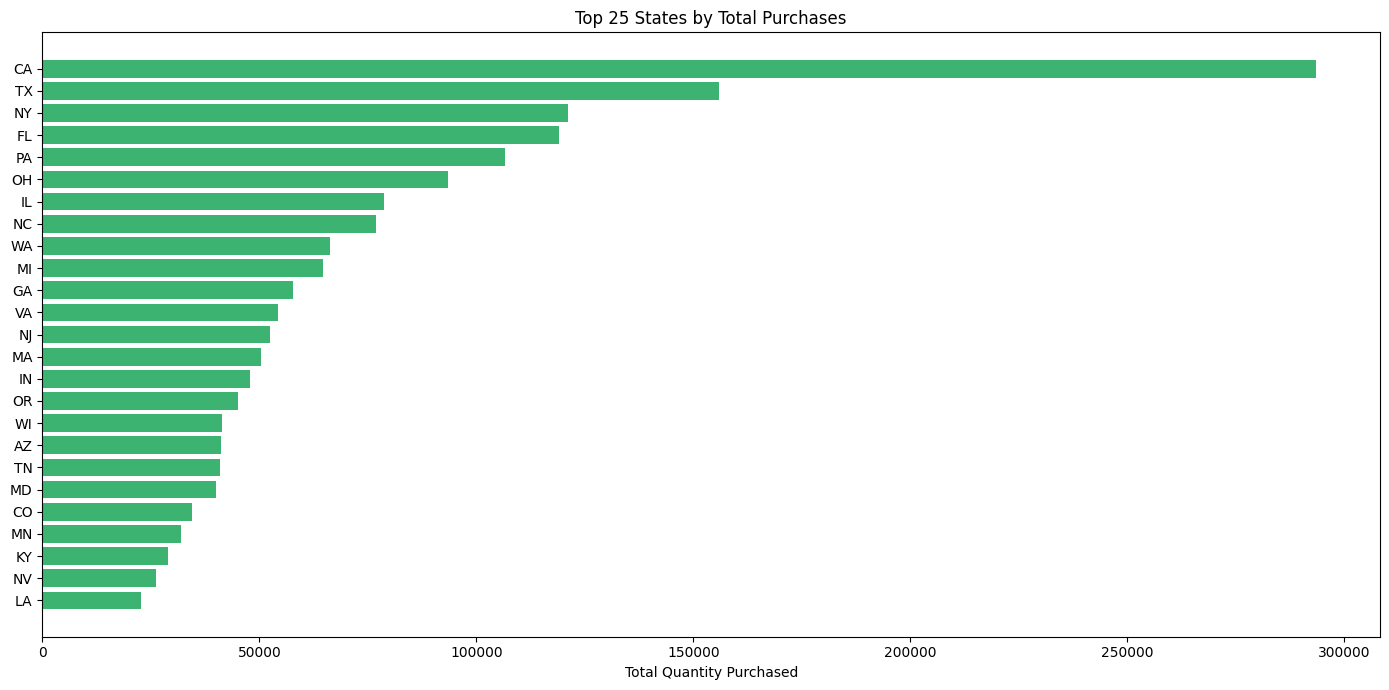

In [ ]:
# Distribution of Purchases by State (Top 25)

# Group by 'Shipping Address State' and sum 'Quantity'
state_distribution = cleaned_data.groupBy("Shipping Address State") \
    .sum("Quantity") \
    .withColumnRenamed("sum(Quantity)", "Total_Quantity") \
    .orderBy("Total_Quantity", ascending=False) \
    .limit(25)

# Convert to Pandas for visualization
state_distribution_pd = state_distribution.toPandas()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.barh(state_distribution_pd["Shipping Address State"], state_distribution_pd["Total_Quantity"], color='mediumseagreen')
plt.xlabel("Total Quantity Purchased")
plt.title("Top 25 States by Total Purchases")
plt.gca().invert_yaxis()  # So highest is at the top
plt.tight_layout()
plt.show()




*   CA has highest number purchases



## 3.8 Price vs Product Quantity <font color = red>[5 marks]</font> <br>

Identify the Relationship between Price and Quantity

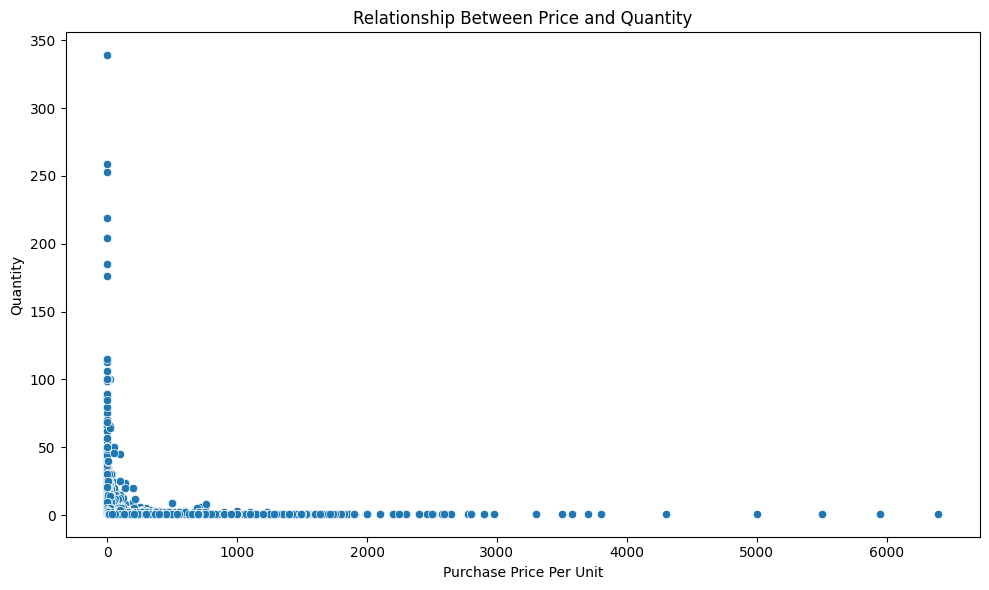

In [ ]:
# Relationship Between Price and Quantity

import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas for visualisation
price_quantity_pd = cleaned_data.select("Purchase Price Per Unit", "Quantity").toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Purchase Price Per Unit", y="Quantity", data=price_quantity_pd)
plt.title("Relationship Between Price and Quantity")
plt.xlabel("Purchase Price Per Unit")
plt.ylabel("Quantity")
plt.tight_layout()
plt.show()



*   The scatter plot shows that higher quantities are typically purchased at lower unit prices.
*   Only a few purchases occur at higher price and quantity combinations.



## 3.9 Analyse the spending KPIs <font color = red>[5 marks]</font> <br>


A popular KPI is average spend per customer. Calculate this metric as the ratio of total transaction amount from non-recurring payments divided by the total number of customers who made a purchase

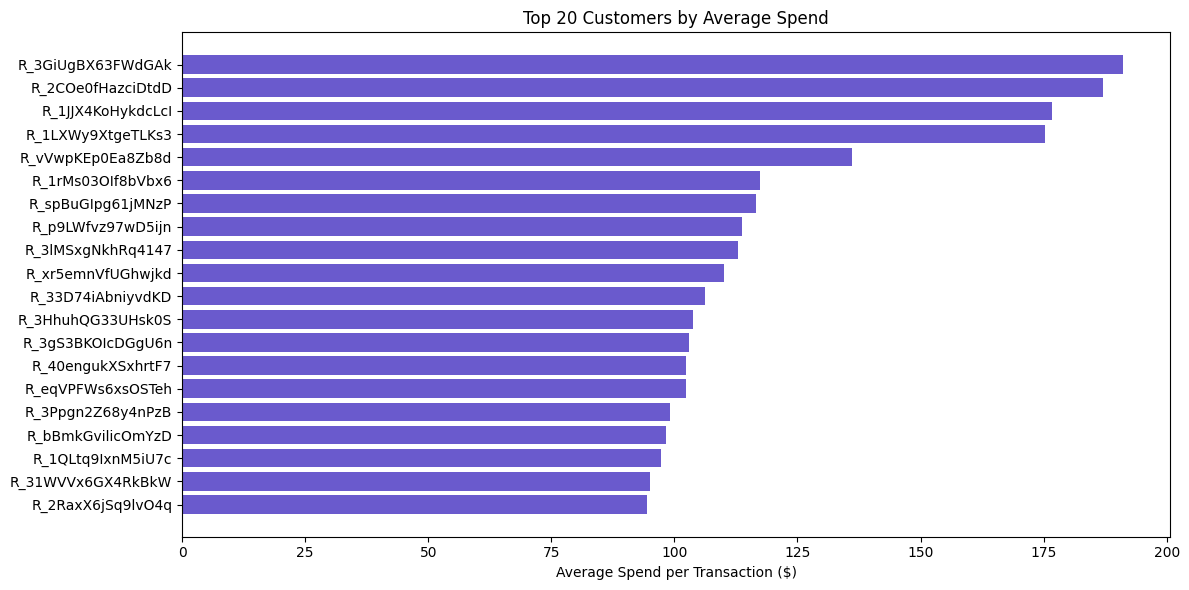

In [ ]:
# Average Spend per Customer

from pyspark.sql.functions import col, sum as _sum, count

#  Add TransactionAmount column
cleaned_data = cleaned_data.withColumn("TransactionAmount", col("Purchase Price Per Unit") * col("Quantity"))

#  Group by customer, calculate total spend and number of transactions
customer_avg_spend = cleaned_data.groupBy("Survey ResponseID") \
    .agg(
        _sum("TransactionAmount").alias("TotalSpend"),
        count("TransactionAmount").alias("TransactionCount")
    ) \
    .withColumn("AverageSpend", col("TotalSpend") / col("TransactionCount"))

# Sort by AverageSpend and select top 20
top_avg_spenders = customer_avg_spend.orderBy("AverageSpend", ascending=False).limit(20)

# Convert to Pandas
top_avg_spenders_pd = top_avg_spenders.select("Survey ResponseID", "AverageSpend").toPandas()
top_avg_spenders_pd = top_avg_spenders_pd.sort_values(by="AverageSpend", ascending=False)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(top_avg_spenders_pd["Survey ResponseID"].astype(str), top_avg_spenders_pd["AverageSpend"], color='slateblue')
plt.xlabel("Average Spend per Transaction ($)")
plt.title("Top 20 Customers by Average Spend")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


* Customer "R_3GiUgBX63FWdGAk" leads with the highest average spend per transaction, approaching $200.

Analyse the Repeat Purchase Behavior of Customers

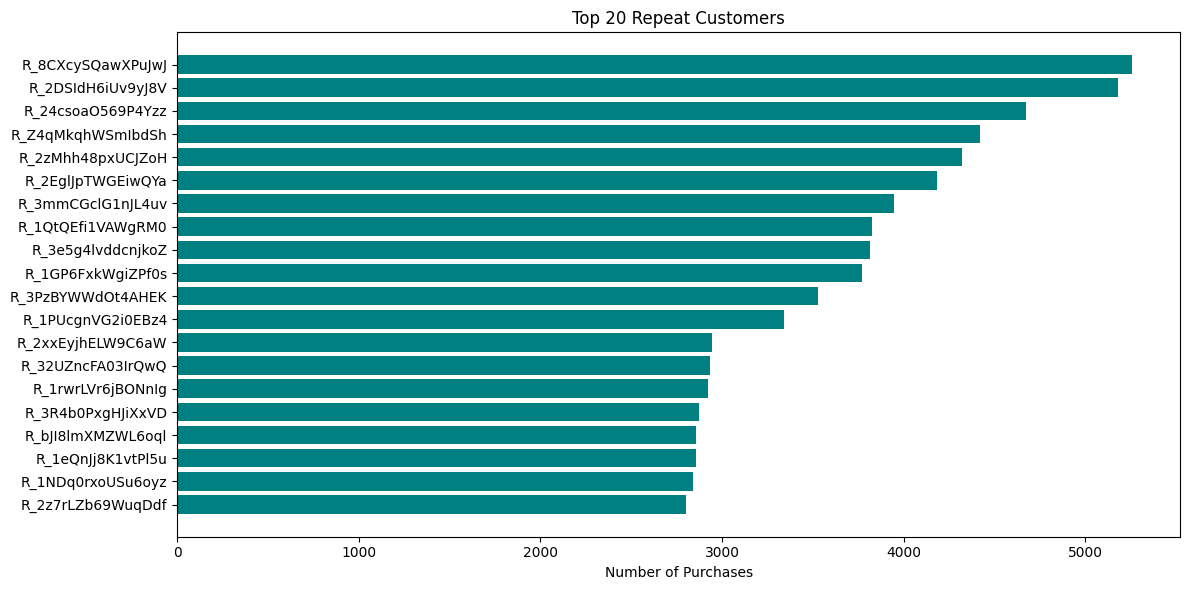

In [ ]:
# Repeat Purchase Analysis Behavior Per Customers

from pyspark.sql.functions import count, col

# Count purchases per customer
repeat_customers = cleaned_data.groupBy("Survey ResponseID") \
    .agg(count("*").alias("PurchaseCount"))

# Filter only those with more than 1 purchase (repeat buyers)
repeat_customers = repeat_customers.filter(col("PurchaseCount") > 1)

# Sort by PurchaseCount in descending order and take top 20
top_repeat_customers = repeat_customers.orderBy("PurchaseCount", ascending=False).limit(20)

# Convert to Pandas
top_repeat_customers_pd = top_repeat_customers.toPandas()
top_repeat_customers_pd = top_repeat_customers_pd.sort_values(by="PurchaseCount", ascending=False)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(top_repeat_customers_pd["Survey ResponseID"].astype(str), top_repeat_customers_pd["PurchaseCount"], color='teal')
plt.xlabel("Number of Purchases")
plt.title("Top 20 Repeat Customers")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()




*   The top customer, 'R_8CXcySQawXPuJWj', made nearly 5,000 purchases, showcasing exceptional loyalty.



Analyse the top 10 high-engagement customers

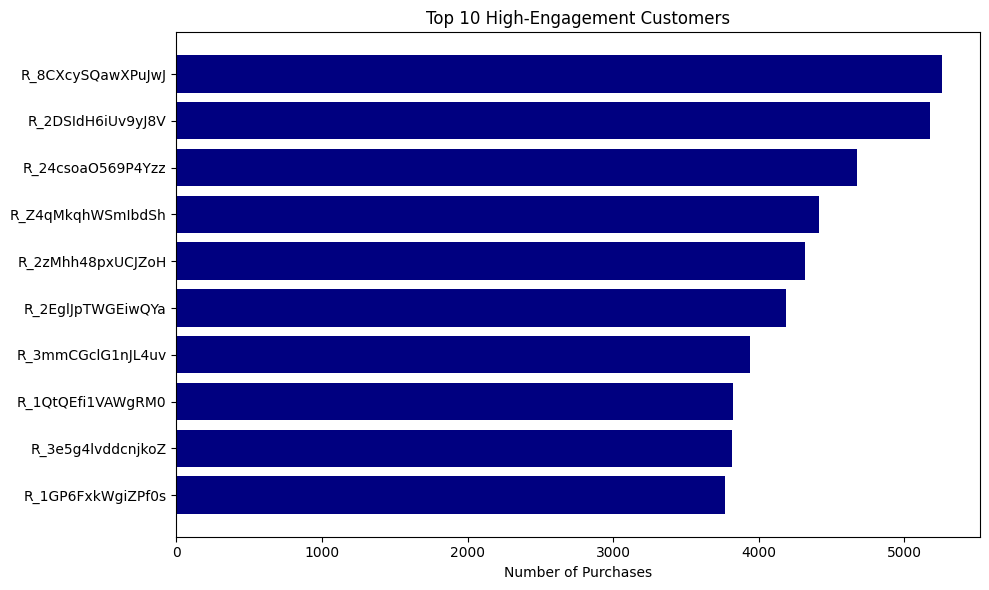

In [ ]:
# Top 10 High-Engagement Customers
from pyspark.sql.functions import col, count

# Count number of purchases per customer
engagement_df = cleaned_data.groupBy("Survey ResponseID") \
    .agg(count("*").alias("PurchaseCount"))

# Sort by PurchaseCount and get top 10
top_engaged_customers = engagement_df.orderBy("PurchaseCount", ascending=False).limit(10)

# Convert to Pandas
top_engaged_customers_pd = top_engaged_customers.toPandas()
top_engaged_customers_pd = top_engaged_customers_pd.sort_values(by="PurchaseCount", ascending=False)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top_engaged_customers_pd["Survey ResponseID"].astype(str), top_engaged_customers_pd["PurchaseCount"], color='navy')
plt.xlabel("Number of Purchases")
plt.title("Top 10 High-Engagement Customers")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()




*   Customer  with ID 'R_8CXcySQawXPuJWj' stands out as the most engaged, with over 5,000 purchases.
*   Customer  with ID 'R_2DSldH6iUv9yJ8V' follows closely with slightly fewer purchases, indicating strong loyalty.



## 3.10 Seasonal trends in product purchases and their impact on revenues <font color = red>[5 marks]</font> <br>

Investigate the seasonal trends in product purchases and their impact on the overall revenue.

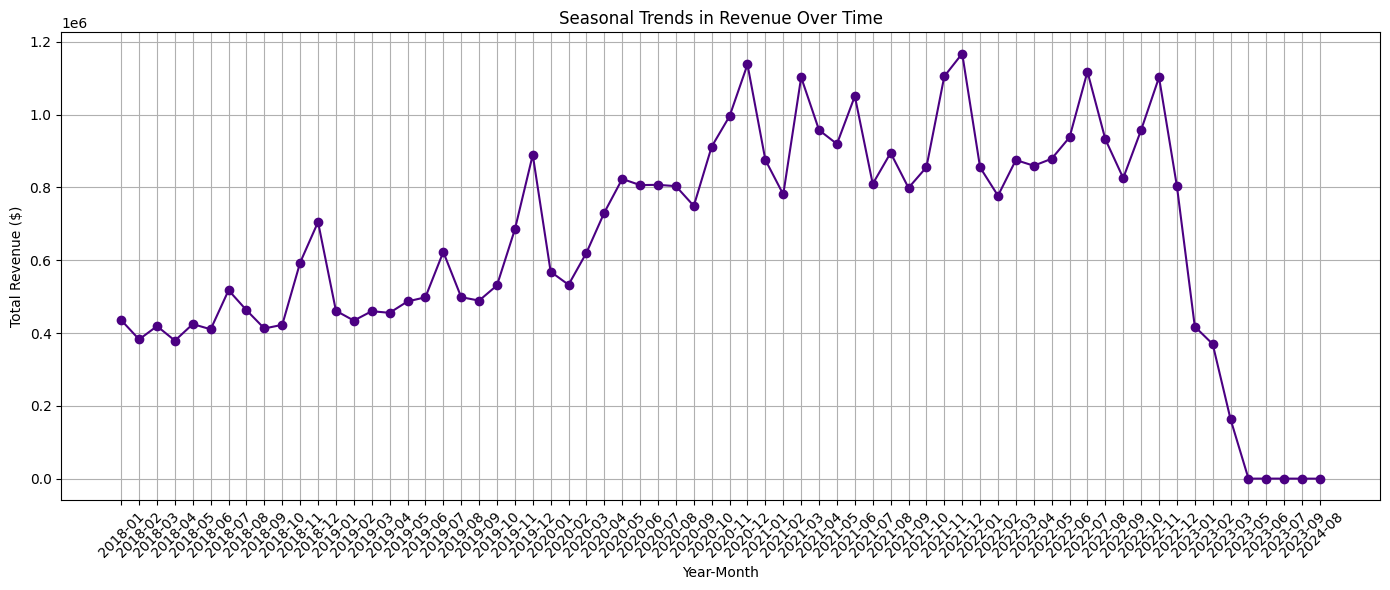

In [ ]:
# Seasonal Trends in Product Purchases and Their Impact on Revenue

from pyspark.sql.functions import year, month, col, sum as _sum



# Calculate revenue per transaction
cleaned_data = cleaned_data.withColumn("Revenue", col("Purchase Price Per Unit") * col("Quantity"))

# Group by year and month, summing total revenue
monthly_revenue = cleaned_data.groupBy("Order Year", "Order Month") \
    .agg(_sum("Revenue").alias("TotalRevenue")) \
    .orderBy("Order Year", "Order Month")

#  Convert to Pandas
monthly_revenue_pd = monthly_revenue.toPandas()

# Create a formatted date column for plotting (e.g., "2023-05")
monthly_revenue_pd["YearMonth"] = monthly_revenue_pd["Order Year"].astype(str) + "-" + monthly_revenue_pd["Order Month"].astype(str).str.zfill(2)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(monthly_revenue_pd["YearMonth"], monthly_revenue_pd["TotalRevenue"], marker='o', color='indigo')
plt.xlabel("Year-Month")
plt.ylabel("Total Revenue ($)")
plt.title("Seasonal Trends in Revenue Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()




*   From 2018 to early 2023, revenue patterns appear relatively consistent, suggesting reliable performance before the decline.
*   A dramatic drop in revenue begins in January 2023, falling to nearly zero by March 2023 and persisting until August 2024



## 3.11 Customer location vs purchasing behavior <font color = red>[5 marks]</font> <br>

Examine the relationship between customer's location and their purchasing behaviors

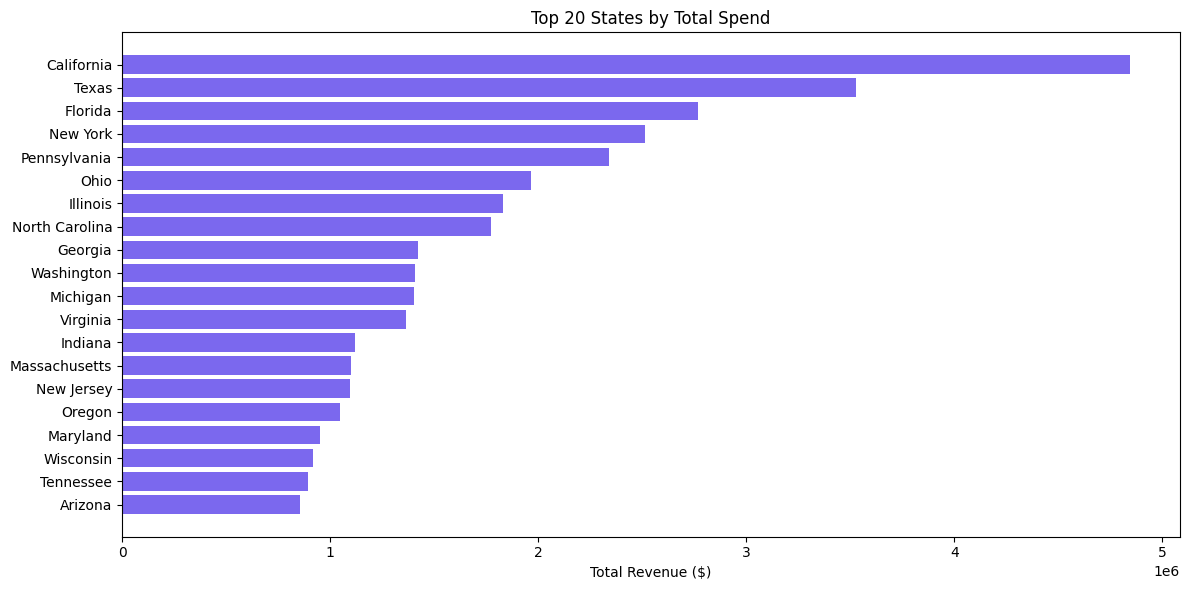

In [ ]:
# Relationship Between Customer Location and Purchase Behavior

from pyspark.sql.functions import col, sum as _sum



# Group by state and calculate total spend
state_spend = cleaned_data.groupBy("State") \
    .agg(_sum("Revenue").alias("TotalRevenue")) \
    .orderBy("TotalRevenue", ascending=False)

# Convert to Pandas
state_spend_pd = state_spend.toPandas()

# Take top 20 states for a cleaner plot
top_states_pd = state_spend_pd.head(20)

# Plot revenue by state
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(top_states_pd["State"], top_states_pd["TotalRevenue"], color='mediumslateblue')
plt.xlabel("Total Revenue ($)")
plt.title("Top 20 States by Total Spend")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()




*   **California Dominates Spending**: California contributes the most, with total revenue nearing $5 million, showcasing significant consumer activity and economic influence
*   **Texas and Florida's Contribution**: Texas and Florida follow as major contributors, with revenue just below California, highlighting strong spending patterns in these states.



#4. Customer Segmentation and Insights <font color = red>[45 marks]</font> <br>


## 4.1 Perform RFM Analysis <font color = red>[10 marks]</font> <br>

RFM Analysis is a powerful customer segmentation technique used to evaluate and quantify customer value based on three key dimensions:
- **Recency**,
- **Frequency**,
- **Monetary**.

This method is particularly effective in identifying high-value customers, optimizing marketing strategies, and improving customer retention in the e-commerce industry.


### 1. Recency (R)
Recency measures how recently a customer made a purchase Customers who have purchased more recently are more likely to respond to promotions and offers.
- **Application:** By ranking customers based on the number of days since their last transaction, you can prioritize those who are most engaged.

### 2. Frequency (F)
Frequency counts the number of purchases a customer has made over a given period.
Frequent purchasers tend to be more loyal and are often a source of recurring revenue.
- **Application:** Analyzing purchase frequency helps in identifying consistent buyers and understanding their buying patterns.

### 3. Monetary (M)
Monetary value represents the total amount of money a customer has spent.
Customers who spend more are often more profitable, making them ideal targets for retention and upsell strategies.
- **Application:** By assessing the monetary contribution, you can distinguish between high-value and low-value customers.


### Prepare data for RFM Analysis <font color = red>[2 marks]</font> <br>


In [ ]:
from pyspark.sql.functions import datediff, max, count, sum, lit, col, to_date



#  Get the latest order date in the dataset
max_order_date = cleaned_data.agg(max("Order Date")).collect()[0][0]

#  Calculate RFM metrics per customer
rfm_df = cleaned_data.withColumn("TotalAmount", col("Purchase Price Per Unit") * col("Quantity")) \
    .groupBy("Survey ResponseID") \
    .agg(
        datediff(lit(max_order_date), max("Order Date")).alias("Recency"),
        count("Order Date").alias("Frequency"),
        sum("TotalAmount").alias("Monetary")
    )

#  Filter out customers with no purchases
rfm_df = rfm_df.filter((col("Frequency") > 0) & (col("Monetary") > 0))

#  Show the RFM data
rfm_df.show()


+-----------------+-------+---------+------------------+
|Survey ResponseID|Recency|Frequency|          Monetary|
+-----------------+-------+---------+------------------+
|R_10TV1zyi4yCEEkl|    525|     1124|29788.359999999953|
|R_2c6ZPDvvitYUf1E|    651|       74|            1253.0|
|R_24f9hBh5NSWGX7k|    650|      179|2698.7900000000004|
|R_2cmFD4NTF42JLfH|    577|      894|28383.099999999966|
|R_1gG5xibh48txT6f|    523|      611|13311.660000000003|
|R_1l6oxKA9uiM9GUo|    632|      174| 5240.860000000001|
|R_1eWdieBjoYJXAYv|    606|      965|27099.969999999972|
|R_297dOANqCntVXou|    600|      588|11329.400000000007|
|R_1esG9Jlh9NISLaO|    529|      368| 6881.200000000002|
|R_1CqGMkfiCiATbn4|    528|      183|           5691.15|
|R_1QgWXnlpERvWjrY|    645|       89|           1515.41|
|R_1jO4s7oht3pyKEc|    518|      628|13287.830000000005|
|R_1li5HiNnFHiD7yw|    533|      158|           3317.17|
|R_21vtzOUrbyaVnsL|    797|       71|1111.8999999999999|
|R_1mxX9jjBSLwxiDU|    524|    

In [ ]:
from pyspark.sql.functions import log1p
from sklearn.preprocessing import StandardScaler

# Apply log transformation to skewed RFM features
rfm_log = rfm_df.withColumn("Recency_log", log1p("Recency")) \
                .withColumn("Frequency_log", log1p("Frequency")) \
                .withColumn("Monetary_log", log1p("Monetary"))

# Select only log-transformed columns and convert to Pandas
rfm_pd = rfm_log.select("Recency_log", "Frequency_log", "Monetary_log").toPandas()

# Scale features using StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_pd)

# convert back to a DataFrame with column names
import pandas as pd
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=["Recency_scaled", "Frequency_scaled", "Monetary_scaled"])
# Display Sample Scaled Data**
print(rfm_scaled_df.head())


   Recency_scaled  Frequency_scaled  Monetary_scaled
0       -0.748652          1.370403         1.438275
1        0.357463         -0.787398        -1.041406
2        0.349557         -0.089816        -0.441147
3       -0.263065          1.188161         1.400450
4       -0.768274          0.885301         0.807801


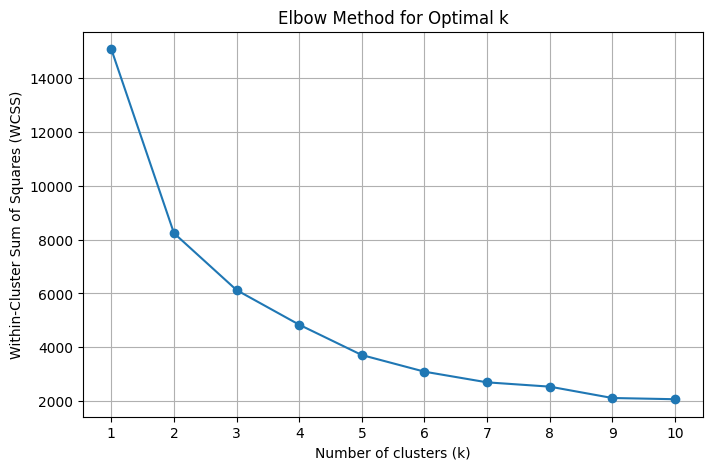

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate the Within-Cluster Sum of Squares (WCSS)
# List to store WCSS for each k
wcss = []

# Try k from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ is WCSS

# Plot the elbow curve with the number of clusters on the x-axis and WCSS on the y-axis
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


In [ ]:
# The WCSS drops sharply from k = 1 to k = 3
# After k = 3 the curve starts to flatten, meaning additional clusters don't significantly improve the compactness of the clusters.
from sklearn.cluster import KMeans
import pandas as pd

#  Fit KMeans with optimal number of clusters
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
rfm_scaled_df["Cluster"] = kmeans.fit_predict(rfm_scaled)

#  Convert back to PySpark DataFrame (optional)
from pyspark.sql import SparkSession

# Initialize SparkSession if not already available
spark = SparkSession.builder.getOrCreate()

# Convert Pandas DataFrame to PySpark
rfm_clustered_spark = spark.createDataFrame(rfm_scaled_df)

# Show sample output
rfm_clustered_spark.show(10)


+--------------------+--------------------+-------------------+-------+
|      Recency_scaled|    Frequency_scaled|    Monetary_scaled|Cluster|
+--------------------+--------------------+-------------------+-------+
| -0.7486516327251332|  1.3704034113349322| 1.4382754995865508|      1|
| 0.35746345326197876| -0.7873978396289131|-1.0414064462469543|      0|
| 0.34955728125542085|-0.08981566930093987|-0.4411474143996195|      0|
|-0.26306543264375065|   1.188161353212694| 1.4004501678028372|      1|
| -0.7682740185549535|  0.8853007285332795| 0.8078011744337539|      1|
| 0.20513090237255566|-0.11226250338649116|0.07822510457038737|      0|
|-0.01090498907127...|  1.2489899145155705| 1.3642393428225357|      1|
|-0.06207299313310...|  0.8547780491503028| 0.6815975670947366|      1|
| -0.7096297032846576|  0.4821661953708955| 0.2913447326012573|      1|
| -0.7193575060834594|-0.07230265850324924| 0.1427348009759865|      0|
+--------------------+--------------------+-------------------+-

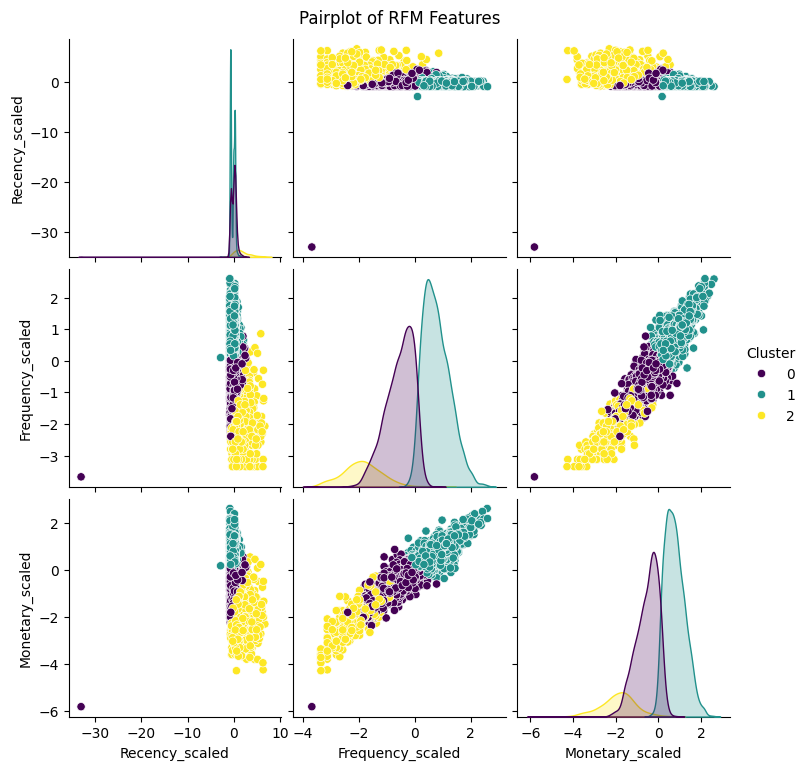

In [ ]:
# Convert the full RFM dataset from PySpark DataFrame to Pandas DataFrame for visualisation
rfm_pandas = rfm_clustered_spark.toPandas()  # rfm_final includes Survey ResponseID, RFM values, and Cluster
import seaborn as sns
import matplotlib.pyplot as plt


# Generate a pairplot to visualise the relationships between the numeric RFM columns
sns.pairplot(rfm_pandas, hue="Cluster", diag_kind="kde", palette="viridis")

plt.suptitle("Pairplot of RFM Features", y=1.02)
plt.show()



*   Cluster 1 Customers have the highest frequency and monetary values.Their recency is the best, meaning they purchased very recently.These are the most valuable and loyal customers.



### Behavioral Trends Analysis <font color = red>[8 marks]</font> <br>

Perform RFM analysis to study the behavior of customers to tailor marketing strategies

In [ ]:
# Import necessary PySpark functions for data processing
from pyspark.sql.functions import col, max, datediff, countDistinct, sum as _sum, lit
from pyspark.sql import functions as F
from sklearn.preprocessing import StandardScaler
from pyspark.sql import SparkSession

# Get the latest order date in the dataset
latest_order_date = cleaned_data.select(max("Order Date")).collect()[0][0]

#  Calculate RFM metrics grouped by Survey ResponseID
rfm_df = cleaned_data.groupBy("Survey ResponseID").agg(
    # Recency: Days since last purchase
    datediff(lit(latest_order_date), max("Order Date")).alias("Recency"),

    # Frequency: Count of distinct purchases (ASIN/ISBN)
    countDistinct("ASIN/ISBN (Product Code)").alias("Frequency"),

    # Monetary: Total spending (price per unit * quantity)
    _sum(col("Purchase Price Per Unit") * col("Quantity")).alias("Monetary")
)

# filter out users with no frequency
rfm_df = rfm_df.filter(col("Frequency") > 0)

# Normalize the distributions with log transformation
from pyspark.sql.functions import log1p

rfm_df = rfm_df.withColumn("Recency_log", log1p("Recency")) \
               .withColumn("Frequency_log", log1p("Frequency")) \
               .withColumn("Monetary_log", log1p("Monetary"))

# Convert to Pandas DataFrame for sklearn clustering
rfm_pandas = rfm_df.select("Survey ResponseID", "Recency_log", "Frequency_log", "Monetary_log").toPandas()

# Scale features using StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_pandas[["Recency_log", "Frequency_log", "Monetary_log"]])

# Store scaled data back into DataFrame with column names
import pandas as pd
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=["Recency", "Frequency", "Monetary"])
rfm_scaled_df["Survey ResponseID"] = rfm_pandas["Survey ResponseID"]
rfm_scaled_df.head()

,Recency,Frequency,Monetary,Survey ResponseID
0,-0.748652,1.512330,1.438275,R_10TV1zyi4yCEEkl
1,-0.817660,0.996992,0.806399,R_1jO4s7oht3pyKEc
2,-0.010905,1.369961,1.364239,R_1eWdieBjoYJXAYv
3,-0.062073,0.962538,0.681598,R_297dOANqCntVXou
4,-0.837547,1.210538,1.026342,R_3GD1CL4OyjglmbZ


In [ ]:
from sklearn.cluster import KMeans
import pandas as pd

# Based on elbow plot optimal_k=3
optimal_k = 3

#  Fit KMeans and predict clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_scaled_df["Cluster"] = kmeans.fit_predict(rfm_scaled_df[["Recency", "Frequency", "Monetary"]])

#  View a sample of the clustered data
print(rfm_scaled_df.head())

#  Convert back to PySpark DataFrame
rfm_clustered_spark = spark.createDataFrame(rfm_scaled_df)


    Recency  Frequency  Monetary  Survey ResponseID  Cluster
0 -0.748652   1.512330  1.438275  R_10TV1zyi4yCEEkl        1
1 -0.817660   0.996992  0.806399  R_1jO4s7oht3pyKEc        1
2 -0.010905   1.369961  1.364239  R_1eWdieBjoYJXAYv        1
3 -0.062073   0.962538  0.681598  R_297dOANqCntVXou        1
4 -0.837547   1.210538  1.026342  R_3GD1CL4OyjglmbZ        1


Analyse the Cluster Distribution by Income <font color = red>[2 marks]</font> <br>


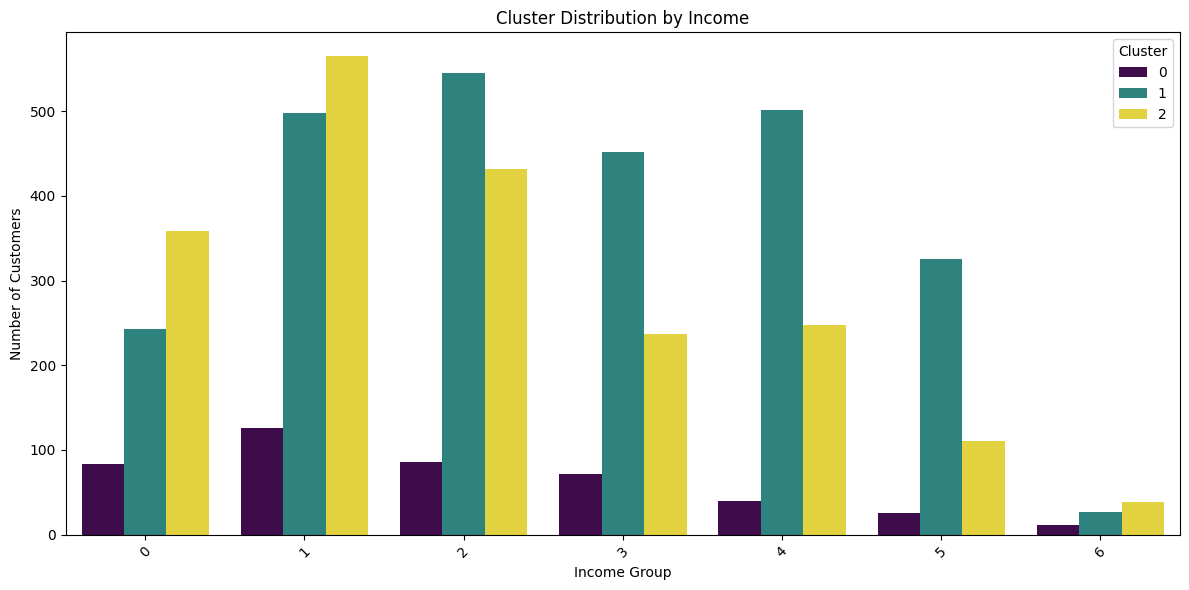

In [ ]:
#Trend 1: Cluster Distribution by Income

# Import the necessary function for counting records in PySpark
from pyspark.sql.functions import count
import seaborn as sns
import matplotlib.pyplot as plt

# Join clustered RFM data with original cleaned_data

rfm_with_income = rfm_clustered_spark.join(
    cleaned_data.select("Survey ResponseID", "income").dropDuplicates(),
    on="Survey ResponseID",
    how="inner"
)

#  Aggregate data to count the number of customers per Cluster-Income group
income_cluster_counts = rfm_with_income.groupBy("Cluster", "income").agg(
    count("*").alias("Customer_Count")
)

# Convert to Pandas for plotting
income_cluster_pandas = income_cluster_counts.toPandas()

#  Plot the distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=income_cluster_pandas, x="income", y="Customer_Count", hue="Cluster", palette="viridis")

plt.title("Cluster Distribution by Income")
plt.xlabel("Income Group")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()




*   Cluster 1 Targets Higher-Income Segments: It shows significant representation in income groups 2, 3, and 4, with a peak at group 4 (\$100,000–\$149,999). This indicates that customers with higher spending potential predominantly belong to Cluster 1.
*   Cluster 0 Captures Lower-Income Customers: This cluster shows the smallest number of customers overall but has its highest engagement in income group 1('\$25,000 - $49,999'), highlighting its focus on a budget-conscious demographic.



Analyse the Average Spending by Cluster <font color = red>[2 marks]</font> <br>


<ipython-input-27-0d6081ef7d96>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summary_pd, x="Cluster", y="Avg_Monetary", palette="viridis")


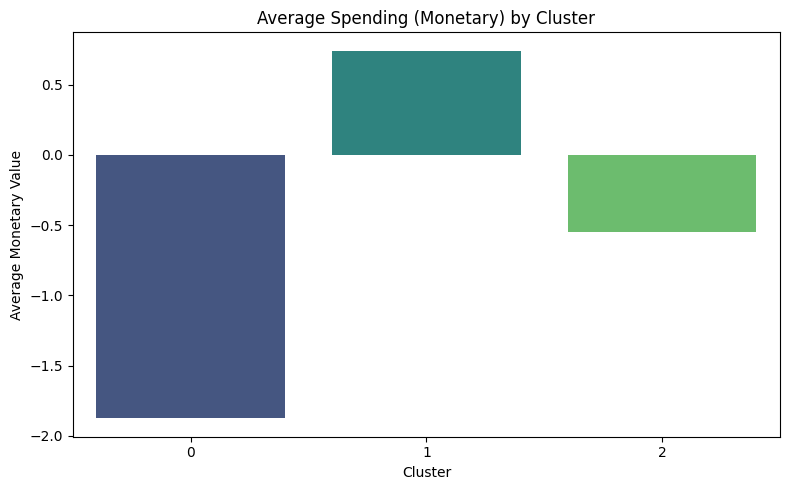

In [ ]:
#Trend 2: Average Spending by Cluster

# Import the required function for calculating averages in PySpark
from pyspark.sql.functions import avg
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the average values of 'Recency_log', 'Frequency', and 'Monetary_log' for each customer cluster
cluster_summary = rfm_clustered_spark.groupBy("Cluster").agg(
    avg("Recency").alias("Avg_Recency"),
    avg("Frequency").alias("Avg_Frequency"),
    avg("Monetary").alias("Avg_Monetary")
)

# Convert the aggregated cluster summary from PySpark DataFrame to Pandas DataFrame for visualisation
cluster_summary_pd = cluster_summary.toPandas()

# Generate a bar plot to visualise the average monetary spending per cluster
plt.figure(figsize=(8, 5))
sns.barplot(data=cluster_summary_pd, x="Cluster", y="Avg_Monetary", palette="viridis")

plt.title("Average Spending (Monetary) by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Monetary Value")
plt.tight_layout()
plt.show()




*   Cluster 1 Has the Highest Spend: Customers in Cluster 1 demonstrate significantly higher average monetary spending (approx. $1.0), suggesting they are the most valuable segment.
*   Cluster 0 Represents the Lowest Spend: With an average monetary value of approximately -1.5, this cluster reflects low-value customers, likely aligning with lower-income groups.



Analyse the Purchase Frequency vs. Recency <font color = red>[2 marks]</font> <br>


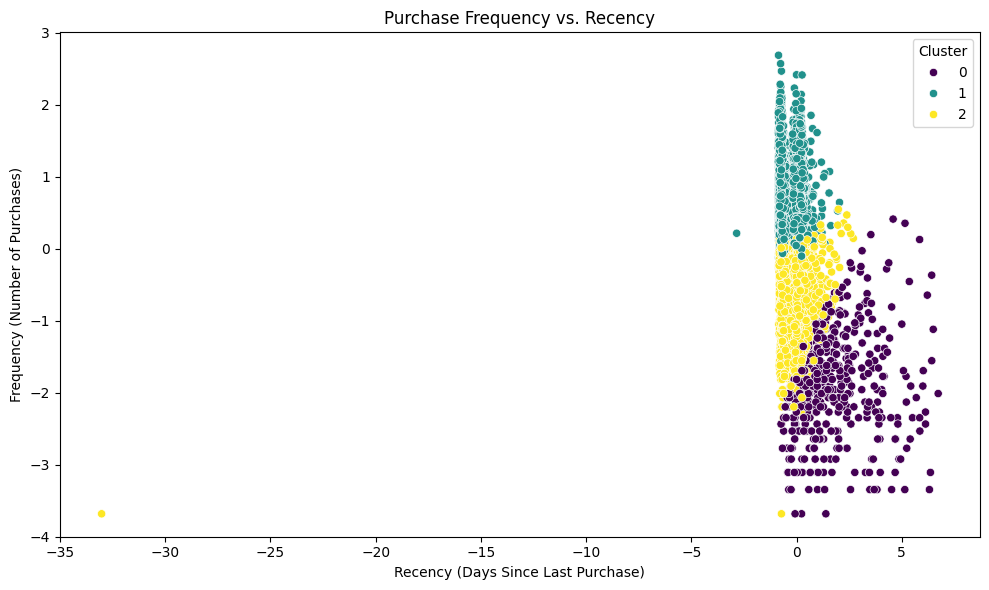

In [ ]:
#Trend 3: Purchase Frequency vs. Recency
import seaborn as sns
import matplotlib.pyplot as plt

# Convert RFM dataset to Pandas
rfm_for_scatter = rfm_clustered_spark.select("Recency", "Frequency", "Cluster").toPandas()

# Generate a scatter plot to analyse the relationship between Purchase Frequency and Recency
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_for_scatter, x="Recency", y="Frequency", hue="Cluster", palette="viridis")

plt.title("Purchase Frequency vs. Recency")
plt.xlabel("Recency (Days Since Last Purchase)")
plt.ylabel("Frequency (Number of Purchases)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()




*   Cluster 1 : These customers are high-frequency and highly recent buyers (towards the top-left of the main cluster). They are the most active and engaged customers, making frequent purchases recently.
*   Cluster 2 (yellow): These customers show moderate frequency and recency. They are a middle-tier group—not as active or recent as Cluster 1, but more engaged than Cluster 0. They may need light nurturing or promotions to boost activity.
*  Cluster 0 (purple): This group has the lowest purchase frequency and higher recency values (meaning they haven’t purchased in a while). They are the least engaged customers



Analyse the top categories by clusters <font color = red>[2 marks]</font> <br>


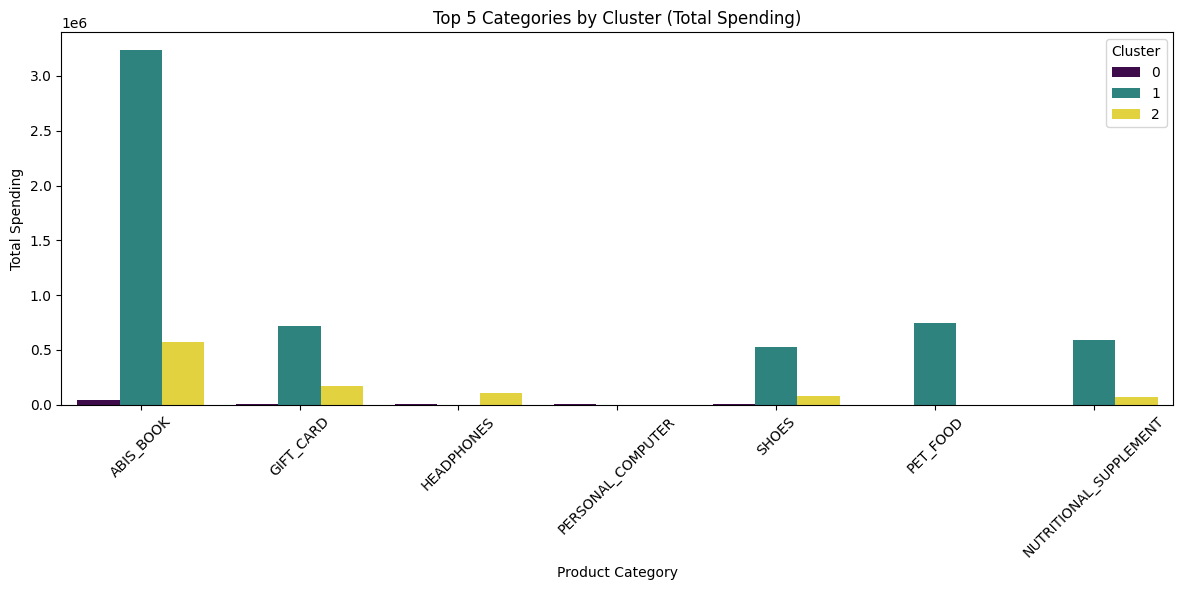

In [ ]:
#Trend 4: Top Categories by Cluster

# Import the necessary function to calculate the sum in PySpark
from pyspark.sql.functions import col, sum as _sum

#  Join the clustered RFM data with the original cleaned_data to bring in 'Category' info
rfm_category_joined = cleaned_data.join(
    rfm_clustered_spark.select("Survey ResponseID", "Cluster"),
    on="Survey ResponseID",
    how="inner"
)

#  Group by Cluster and Category, compute total spending (price * quantity)
category_spending = rfm_category_joined.groupBy("Cluster", "Category").agg(
    _sum(col("Purchase Price Per Unit") * col("Quantity")).alias("Total_Spending")
)

# For each cluster, get top 5 categories by spending
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

window_spec = Window.partitionBy("Cluster").orderBy(col("Total_Spending").desc())

top_categories_by_cluster = category_spending.withColumn("Rank", row_number().over(window_spec)) \
                                             .filter(col("Rank") <= 5)

#  Convert to Pandas for visualization
top_categories_pd = top_categories_by_cluster.toPandas()

#  Plot the results
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_categories_pd,
    x="Category",
    y="Total_Spending",
    hue="Cluster",
    palette="viridis"
)

plt.title("Top 5 Categories by Cluster (Total Spending)")
plt.xlabel("Product Category")
plt.ylabel("Total Spending")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()




*   Cluster 1 Leads Spending in Major Categories: This cluster shows the highest total spending across key categories, particularly for ABIS_BOOK and GIFT_CARD. These individuals represent your most valuable customers.
*   Cluster 2  Shows Moderate Activity: While less dominant than Cluster 1, Most spending concentrated in:ABIS_BOOK and GIFT_CARD
*   Cluster 0 (Dark Purple) – Low Engagement, Low Value
Minimal total spending across all categories.Slight presence in ABIS_BOOK and GIFT_CARD, but overall contribution is negligible.



## 4.2 Insights <font color = red>[35 marks]</font> <br>


### 4.2.1 When to schedule effective promotions. <font color = red>[3 marks]</font> <br>

Compare sales across weekdays to schedule effective promotions

<ipython-input-60-e2c393d90443>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weekday_sales_pd, x="Weekday", y="TotalSales", palette="viridis")


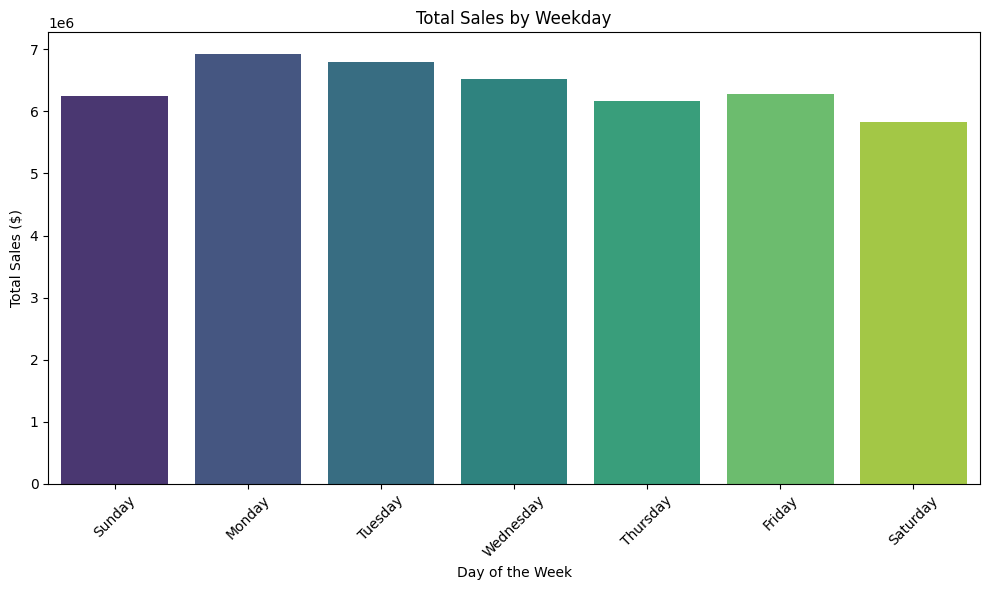

In [ ]:
#Compare sales across weekdays to schedule effective promotions

from pyspark.sql.functions import dayofweek, col, expr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract weekday (1 = Sunday, ..., 7 = Saturday)
cleaned_data = cleaned_data.withColumn("Weekday", dayofweek("Order Date"))

# Create a 'Total Sale' column
cleaned_data = cleaned_data.withColumn("TotalSale", col("Purchase Price Per Unit") * col("Quantity"))

# Step 3: Group by Weekday and sum total sales
weekday_sales = cleaned_data.groupBy("Weekday").sum("TotalSale").withColumnRenamed("sum(TotalSale)", "TotalSales")

# Step 4: Convert to Pandas for visualization
weekday_sales_pd = weekday_sales.toPandas()

# Step 5: Map weekday numbers to names
weekday_map = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday",
               5: "Thursday", 6: "Friday", 7: "Saturday"}
weekday_sales_pd["Weekday"] = weekday_sales_pd["Weekday"].map(weekday_map)

# Optional: Sort by weekday order
weekday_sales_pd["Weekday"] = pd.Categorical(weekday_sales_pd["Weekday"],
                                             categories=["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"],
                                             ordered=True)
weekday_sales_pd.sort_values("Weekday", inplace=True)

# Step 6: Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=weekday_sales_pd, x="Weekday", y="TotalSales", palette="viridis")
plt.title("Total Sales by Weekday")
plt.ylabel("Total Sales ($)")
plt.xlabel("Day of the Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





*   Highest Sales on Monday: Mondays lead the chart, indicating strong consumer activity at the beginning of the week.
*   Lowest Sales on Sunday: Sundays see the least sales, suggesting potential opportunities for promotional campaigns to boost activity.



### 4.2.2 Top-selling Products <font color = red>[2 marks]</font> <br>

Identify top-selling products by considering revenue and engagement metrics

<ipython-input-64-4205b45e2d47>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products_pd, y="Title", x="TotalRevenue", palette="magma")
<ipython-input-64-4205b45e2d47>:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


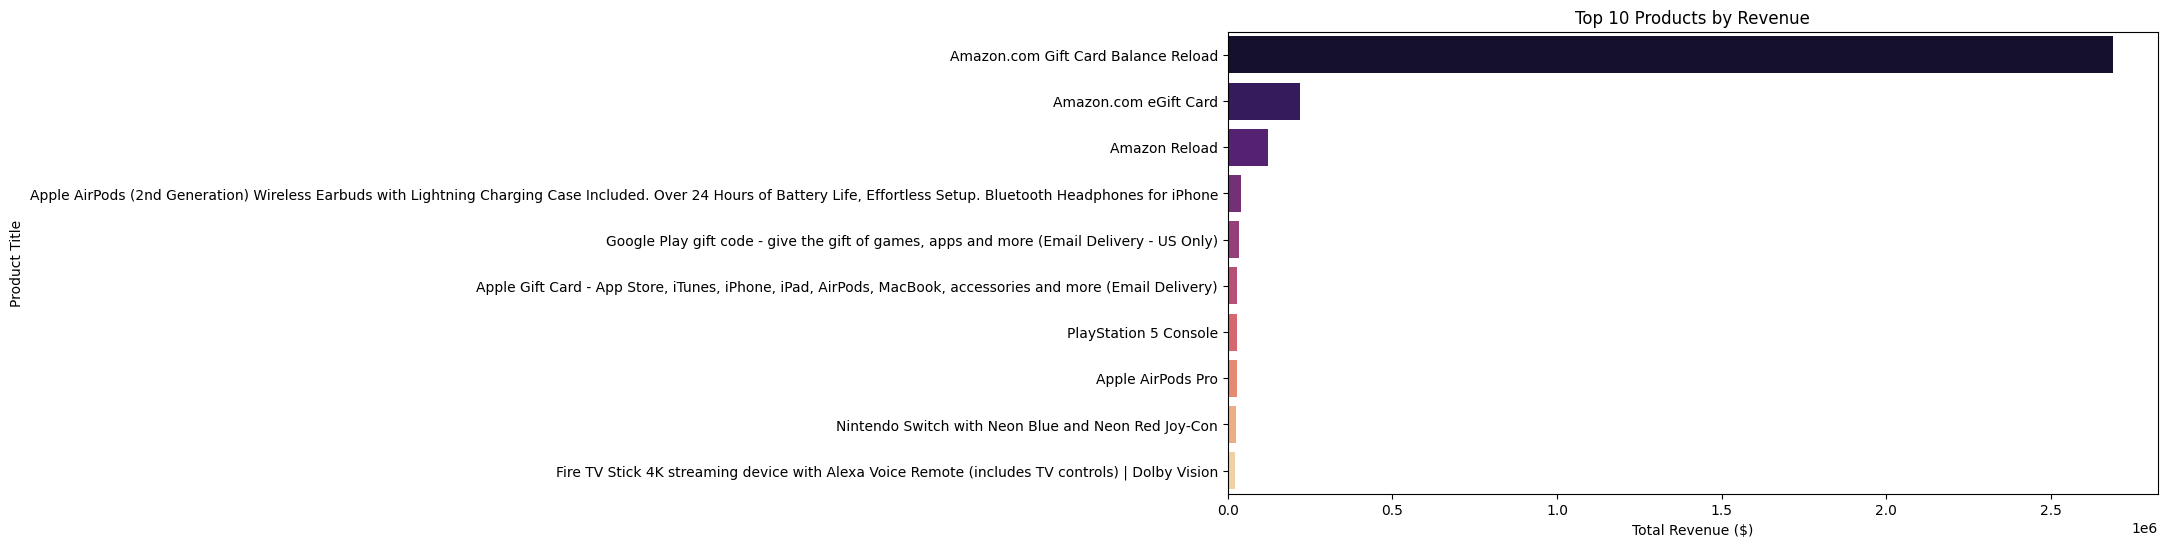

In [ ]:
#Identify top-selling products using revenue and engagement metrics
from pyspark.sql.functions import col


# Group by product and sum revenue
product_sales = cleaned_data.groupBy("Title").agg(
    {"Revenue": "sum", "Quantity": "sum"}
).withColumnRenamed("sum(Revenue)", "TotalRevenue") \
 .withColumnRenamed("sum(Quantity)", "TotalQuantity")

# Get top 10 products by revenue
top_products = product_sales.orderBy(col("TotalRevenue").desc()).limit(10)

# Convert to Pandas for visualization
top_products_pd = top_products.toPandas()

# Plot top products by revenue
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=top_products_pd, y="Title", x="TotalRevenue", palette="magma")
plt.title("Top 10 Products by Revenue")
plt.xlabel("Total Revenue ($)")
plt.ylabel("Product Title")
plt.tight_layout()
plt.show()




*   Products like "Amazon.com Gift Card Balance Reload," "Amazon eGift Card," and "Amazon Reload" take the top three positions, showcasing their immense popularity and profitability
*   Items like "Apple AirPods" and the "PlayStation 5 Console" rank high, indicating a strong consumer preference for premium technology.



### 4.2.3 State-wise revenue Distribution <font color = red>[5 marks]</font> <br>

Assess state-wise revenue to focus on high-growth areas

<ipython-input-65-9f51f199efa9>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_revenue_pd, x="state", y="TotalRevenue", palette="crest")


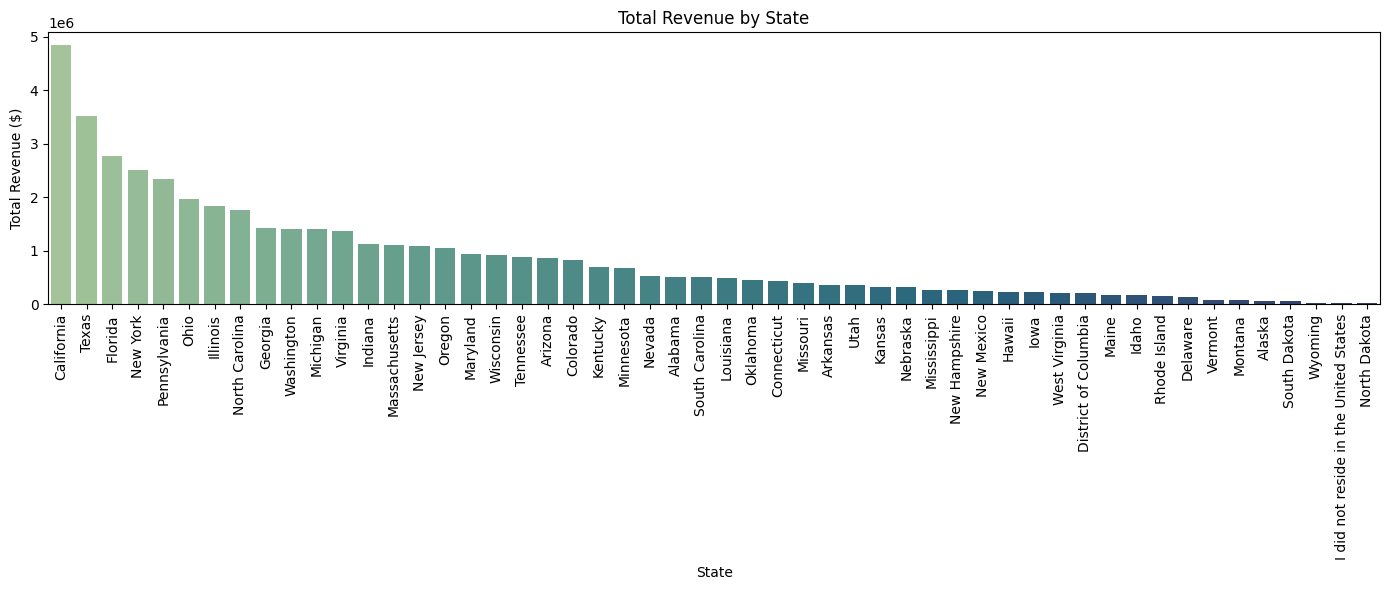

In [ ]:
#Assess state-wise revenue to focus on high-growth areas

from pyspark.sql.functions import col



# Group by user state and sum revenue
state_revenue = cleaned_data.groupBy("state").sum("Revenue").withColumnRenamed("sum(Revenue)", "TotalRevenue")

# Convert to Pandas for visualization
state_revenue_pd = state_revenue.toPandas()

# Sort by revenue descending
state_revenue_pd = state_revenue_pd.sort_values("TotalRevenue", ascending=False)

# Plot revenue by state
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.barplot(data=state_revenue_pd, x="state", y="TotalRevenue", palette="crest")
plt.title("Total Revenue by State")
plt.xlabel("State")
plt.ylabel("Total Revenue ($)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()




*   California leads by a wide margin with revenue near $5 million, making it the top target for marketing and promotions.


*   Texas, Florida, and New York also show strong performance, each generating multi-million dollar revenues.List item



### 4.2.4 Repeat Purchase Behavior <font color = red>[5 marks]</font> <br>

Examine repeat purchase behavior to enhance retention initiatives.

In [ ]:
#Examine repeat purchase behavior to enhance retention initiatives

from pyspark.sql.functions import count

# Count total purchases per customer
customer_purchases = cleaned_data.groupBy("Survey ResponseID").agg(
    count("*").alias("TotalPurchases")
)

# Filter for repeat customers (more than one purchase)
repeat_customers = customer_purchases.filter(col("TotalPurchases") > 1)

# Show a sample of repeat customers
repeat_customers.show(10)


+-----------------+--------------+
|Survey ResponseID|TotalPurchases|
+-----------------+--------------+
|R_10TV1zyi4yCEEkl|          1124|
|R_2c6ZPDvvitYUf1E|            74|
|R_24f9hBh5NSWGX7k|           179|
|R_2cmFD4NTF42JLfH|           894|
|R_1gG5xibh48txT6f|           611|
|R_1l6oxKA9uiM9GUo|           174|
|R_1eWdieBjoYJXAYv|           965|
|R_297dOANqCntVXou|           588|
|R_1esG9Jlh9NISLaO|           368|
|R_1CqGMkfiCiATbn4|           183|
+-----------------+--------------+
only showing top 10 rows



### 4.2.5 Flagging Potential Fraud <font color = red>[5 marks]</font> <br>

Identify irregular transaction patterns to flag potential fraud.

In [ ]:
#Identify irregular transaction patterns to flag potential fraud

from pyspark.sql.functions import col, avg, stddev



# Compute mean and stddev of TotalSale
stats = cleaned_data.agg(
    avg("Revenue").alias("mean_sale"),
    stddev("Revenue").alias("stddev_sale")
).collect()[0]

mean_sale = stats["mean_sale"]
stddev_sale = stats["stddev_sale"]
threshold = mean_sale + 3 * stddev_sale

print(f"Fraud Threshold = {threshold:.2f}")

# Consider spending to be unusually high if the total spent is greater than the mean + 3 * std dev
# Filter transactions exceeding the threshold
suspicious_transactions = cleaned_data.filter(col("Revenue") > threshold)

# Show suspicious transactions
suspicious_transactions.show(10, truncate=False)


Fraud Threshold = 165.23
+-----------------+----------+-----------------------+--------+----------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------+------------------+-------------+----------------------------------+------------------------------------------------+--------------------------------------------------------------------+------+------+-----------------------+----------+------------------+-------------------------+----------------------------+---------+-----------+----------+----------+--------------+-------+-------+-----------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|Title                                                                                                                                                                            

### 4.2.6 Demand Variations across product categories <font color = red>[5 marks]</font> <br>

Perform inventory management by monitoring demand variations across product categories.

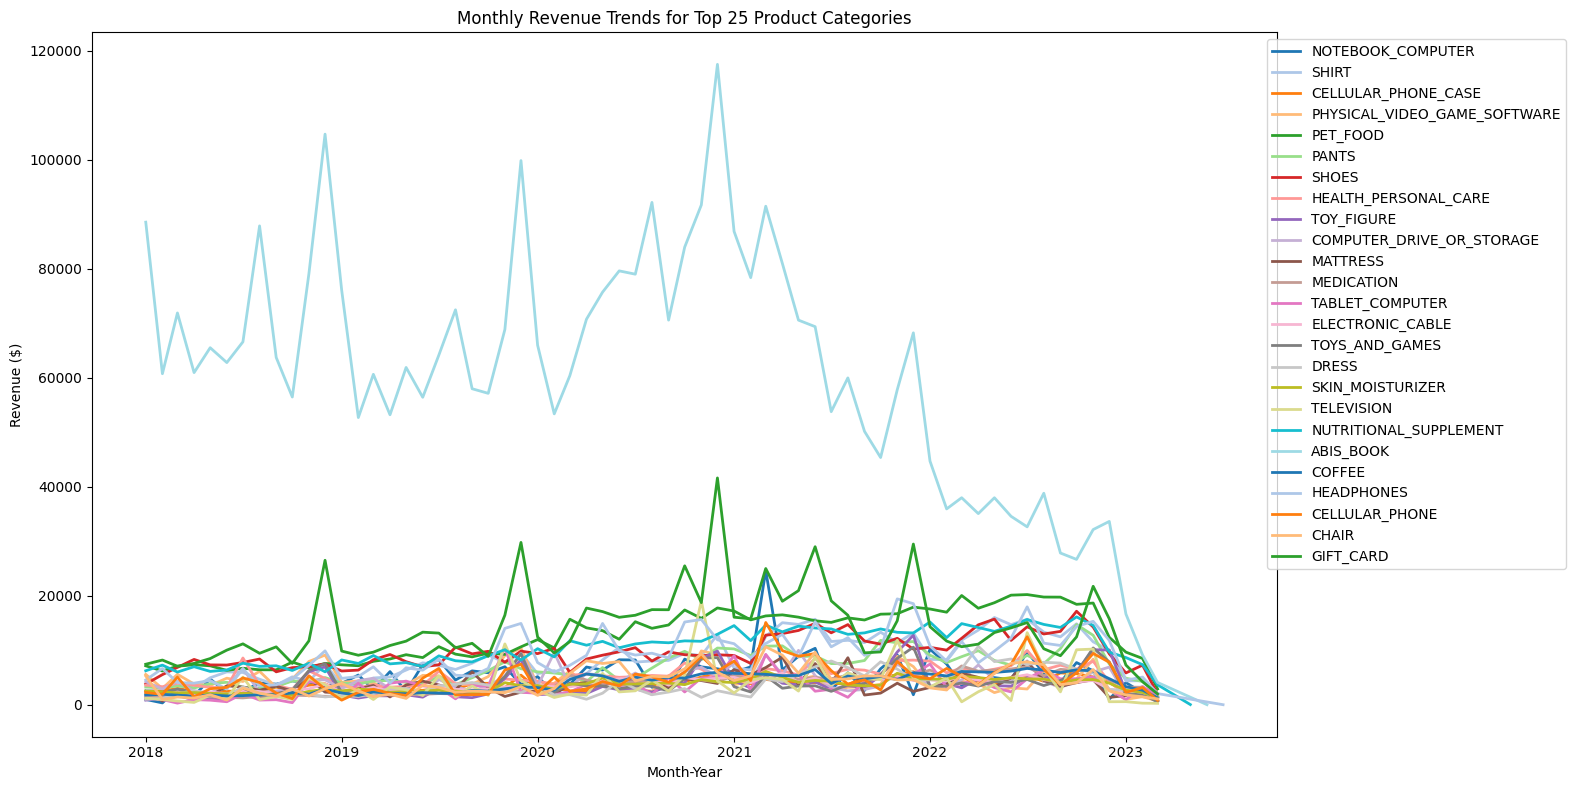

In [ ]:
# Monitor demand variations across product categories (Top 25) for inventory management
from pyspark.sql.functions import col, sum



# Group by Category and Month-Year, summing TotalSale
category_trends = cleaned_data.groupBy("Category", "OrderMonthYear").agg(
    sum("Revenue").alias("MonthlyRevenue")
)

# Compute total revenue per category
total_revenue_by_category = cleaned_data.groupBy("Category").agg(
    sum("Revenue").alias("TotalRevenue")
)

# Get top 25 categories by total revenue
top_25_categories = total_revenue_by_category.orderBy(col("TotalRevenue").desc()).limit(25)
top_25_list = [row["Category"] for row in top_25_categories.collect()]

# Filter trends to only include top 25 categories
category_trends_filtered = category_trends.filter(col("Category").isin(top_25_list))

# Convert to Pandas for visualization
category_trends_pd = category_trends_filtered.toPandas()

# Convert OrderMonthYear to datetime for proper plotting
category_trends_pd["OrderMonthYear"] = pd.to_datetime(category_trends_pd["OrderMonthYear"])

#  Plot revenue trends
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.lineplot(
    data=category_trends_pd,
    x="OrderMonthYear",
    y="MonthlyRevenue",
    hue="Category",
    palette="tab20",
    linewidth=2
)
plt.title("Monthly Revenue Trends for Top 25 Product Categories")
plt.xlabel("Month-Year")
plt.ylabel("Revenue ($)")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()




*   ABIS_BOOK has highest  revenue compared to other product categories.




### 4.2.7 Assess how bulk purchases affect revenue and supply chain operations <font color = red>[5 marks]</font> <br>

Analyse the impact of how bulk purchasing behavior affects revenue and the overall supply chain operations.

<ipython-input-38-eba71144a026>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bulk_top_25_pd, y="Category", x="BulkRevenue", palette="magma")


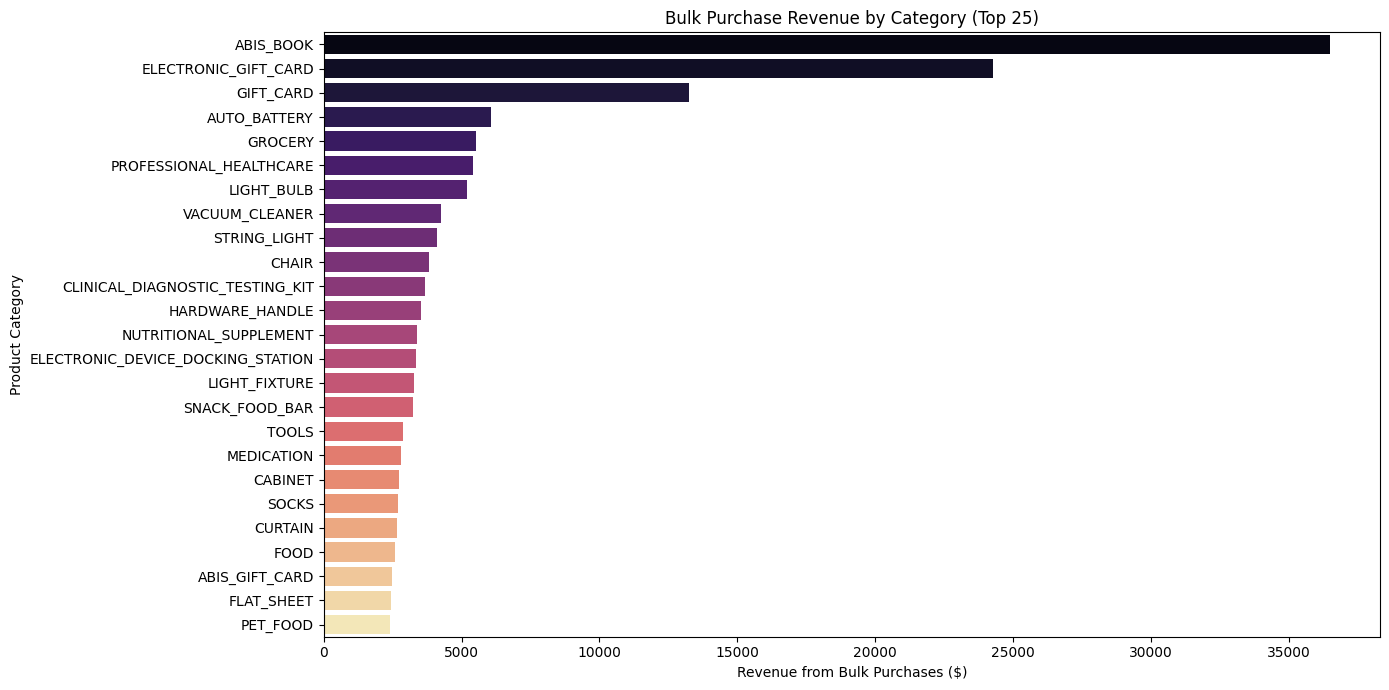

In [ ]:
# Assess how bulk purchases affect revenue and supply chain operations
from pyspark.sql.functions import col, sum


# Filter bulk purchases (Quantity > 5) and compute total revenue per category
bulk_purchases = cleaned_data.filter(col("Quantity") > 5)

# Compute total revenue per category (for bulk purchases)
bulk_revenue_by_category = bulk_purchases.groupBy("Category").agg(
    sum("Revenue").alias("BulkRevenue")
)

# Get top 25 categories by bulk revenue
top_25_bulk_categories = bulk_revenue_by_category.orderBy(col("BulkRevenue").desc()).limit(25)

# Convert to Pandas for visualization
bulk_top_25_pd = top_25_bulk_categories.toPandas()

# Plot bulk revenue by category
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.barplot(data=bulk_top_25_pd, y="Category", x="BulkRevenue", palette="magma")
plt.title("Bulk Purchase Revenue by Category (Top 25)")
plt.xlabel("Revenue from Bulk Purchases ($)")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()




*   The "ABIS_BOOK" category leads with the highest revenue from bulk purchases, far surpassing other categories.
*   "ELECTRONIC_GIFT_CARD" and "GIFT_CARD" rank as the second and third highest revenue generators.



### 4.2.8 Compare lifecycle strategies <font color = red>[5 marks]</font> <br>

Compare new and established products to inform and compare lifecycle strategies to make informed decisions.

<ipython-input-43-edbf12bd71ca>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=revenue_by_launch_year_pd, x="LaunchYear", y="TotalRevenue", palette="viridis")


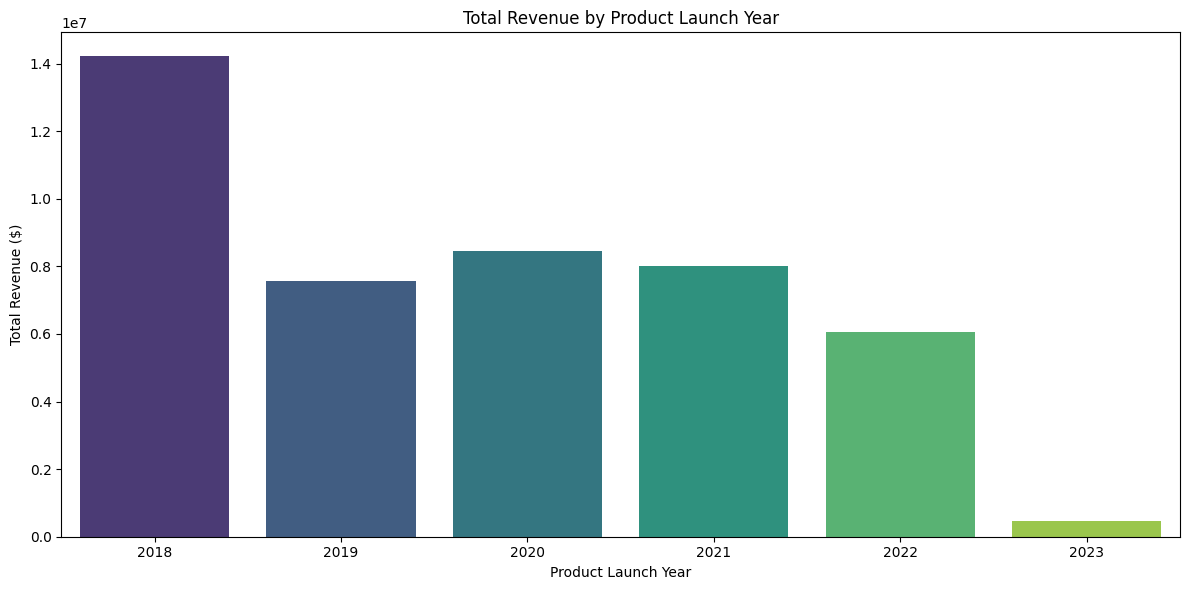

In [ ]:
#Compare new and established products to inform lifecycle strategies

from pyspark.sql.functions import min, sum

# Compute Launch Year for each product (based on earliest order year)
product_launch_year = cleaned_data.groupBy("Title").agg(
    min("Order Year").alias("LaunchYear")
)

# Join launch year back to the main dataset
data_with_launch = cleaned_data.join(product_launch_year, on="Title", how="left")

# Ensure TotalSale is calculated
data_with_launch = data_with_launch.withColumn("TotalSale", col("Purchase Price Per Unit") * col("Quantity"))

# Compute total revenue by product Launch Year
revenue_by_launch_year = data_with_launch.groupBy("LaunchYear").agg(
    sum("TotalSale").alias("TotalRevenue")
)

# Convert to Pandas for plotting
revenue_by_launch_year_pd = revenue_by_launch_year.toPandas().sort_values("LaunchYear")

#  Plot revenue vs. launch year
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=revenue_by_launch_year_pd, x="LaunchYear", y="TotalRevenue", palette="viridis")
plt.title("Total Revenue by Product Launch Year")
plt.xlabel("Product Launch Year")
plt.ylabel("Total Revenue ($)")
plt.tight_layout()
plt.show()




*   Peak Revenue in 2018: The highest total revenue was achieved in 2018, reaching over $14 million. This could reflect strong product launches, robust sales strategies, or favorable market conditions during that year.

*  Despite the overall decline, revenue levels from 2019 to 2022 hover around $10 million, indicating consistent performance before the sharp drop in 2023.



#5 Conclusion <font color = red>[10 marks]</font> <br>

Write your conclusion.

- **Strong Customer Engagement Pre-2023**: From 2018 to 2021, purchases steadily increased, peaking in 2021, driven by pandemic-related online shopping habits.

- **Sharp Decline in 2023–2024**: A sudden and steep drop in purchase volume and revenue from January 2023 onward, possibly due to market saturation, reduced customer interest, or external disruptions.

- **Demographic Insights**:
  - Majority of buyers are females, aged 25–34, and belong to the  100,000– 149,999 income group.
  - Most purchases are from customers identifying as White or Caucasian.

- **State-Level Trends**:
  - California leads both in purchase volume and revenue (~$5M).
  - Texas, Florida, and New York are also top contributors.

- **Product Trends**:
  - Gift cards and personalized items (e.g., photo prints) are top-selling by quantity.
  - ABIS_BOOK dominates revenue, significantly ahead of other categories.
  - High-ticket tech items (e.g., AirPods, PS5) are highly favored.

- **Purchase Behavior**:
  - Most purchases occur on Mondays and Tuesdays.
  - Very few purchases happen on Sundays.
  - Purchases lack hourly granularity — timestamps appear to be missing.

- **Customer Segmentation (RFM Analysis)**:
  - Cluster 1: High-value customers — recent, frequent, and high spenders (mostly high-income).
  - Cluster 2: Moderate engagement, potential to nurture with targeted campaigns.
  - Cluster 0: Low engagement — infrequent purchases, likely inactive or budget-conscious.

- **Price vs Quantity**: Higher quantities are generally bought at lower unit prices; high price–high quantity combinations are rare.

- **Top Customers**:
  - Customer ID R_8CXcySQawXPuJWj made nearly 5,000 purchases, showing strong brand loyalty.
  - R_3GiUgBX63FWdGAk has the highest average spend per transaction (~$200).

- **Recommendations**

  - **Re-engagement Strategy for 2023–24 Decline**:
    - Launch loyalty programs and targeted promotions for Cluster 0 and Cluster 2.
    - Investigate potential external factors behind the drop (e.g., supply chain issues, platform changes).

  - **Promotional Campaigns**:
    - Run Monday promotions to boost already strong traffic.
    - Launch Sunday-specific campaigns to improve low weekend sales.

  - **Customer Retention**:
    - Prioritize Cluster 1 with exclusive deals, early access, or premium membership offers.
    - Provide personalized emails based on their favorite categories (e.g., Books, Gift Cards).

  - **Product Strategy**:
    - Stock more of high-selling and high-margin products like gift cards, books, and tech gadgets.
    - Consider bundling popular items for upselling.

  - **Geographic Marketing**:
    - Focus marketing efforts in California, Texas, Florida, and New York.
    - Use state-wise insights for localized campaigns.

  - **Survey Data Utilization**:
    - Use customer preferences and demographic data to further refine product recommendations and personalized experiences.

  - **Data Improvement**:
    - Capture timestamp information during purchases to allow time-of-day behavior analysis.
    - Clean and validate survey data regularly to ensure completeness and usefulness.
